In [1]:
# ------------------------------------------define logging and working directory
from ProjectRoot import change_wd_to_project_root
change_wd_to_project_root()
import cv2
from ipyfilechooser import FileChooser
from src.utils.Notebook_imports import *
from src.utils.Tensorflow_helper import choose_gpu_by_id
from tensorflow.keras.utils import plot_model
from tensorflow.python.client import device_lib
import tensorflow as tf
tf.get_logger().setLevel('ERROR')
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
# ------------------------------------------define GPU id/s to use
GPU_IDS = '0,1'
GPUS = choose_gpu_by_id(GPU_IDS)
print(GPUS)

# ------------------------------------------jupyter magic config
%matplotlib inline
%reload_ext autoreload
%autoreload 2

# ------------------------------------------ import helpers
from src.utils.Utils_io import Console_and_file_logger, init_config
from src.utils.KerasCallbacks import get_callbacks
import src.utils.Loss_and_metrics as metr
from src.utils.Predict import predict_on_one_3d_file

from src.data.Dataset import get_reference_nrrd, copy_meta_and_save, get_trainings_files
from src.data.Preprocess import from_channel_to_flat, transform_to_binary_mask, normalise_image
from src.data.Generators import DataGenerator, CycleMotionDataGenerator
from src.data.Postprocess import clean_3d_prediction_3d_cc, undo_generator_steps

import src.models.SpatialTransformer as st
from src.models.SpatialTransformer import create_affine_cycle_transformer_model, create_affine_transformer_fixed
from src.models.KerasLayers import UnetWrapper
from src.models.ModelUtils import load_pretrained_model

from src.visualization.Visualize import show_2D_or_3D

# ------------------------------------------these metrics and loss function are meant if you continue training of the U-Net
metrics = [
    metr.dice_coef_labels,
    metr.dice_coef_myo,
    metr.dice_coef_lv,
    metr.dice_coef_rv
]
LOSS_FUNCTION = metr.bce_dice_loss

from tensorflow.keras.mixed_precision import experimental as mixed_precision
logging.info('Is built with tensorflow: {}'.format(tf.test.is_built_with_cuda()))
logging.info('Visible devices:\n{}'.format(tf.config.list_physical_devices()))
logging.info('Local devices: \n {}'.format(device_lib.list_local_devices()))
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_policy(policy)
logging.info('Compute dtype: %s' % policy.compute_dtype)
logging.info('Variable dtype: %s' % policy.variable_dtype)

search for root_dir and set working directory
Working directory set to: /mnt/ssd/git/3d-mri-domain-adaption
['/gpu:0', '/gpu:1']


# Load an ax-sax config into the global namespace

In [2]:
exp_config_chooser = FileChooser(os.path.join(os.getcwd(),'reports/configs/3D/ax_sax/train_on_ax_sax/fold0/2020-12-17_11_44/'), '')
display(exp_config_chooser)
@interact_manual
def load_unet():
    # load a pretrained 2D unet
    global exp_config_chooser, config
    """
    load ax-sax experiment config
    """
    if 'exp_config_chooser' in globals():
        config_file  = exp_config_chooser.selected
    else:
        # round the crop and pad values instead of ceil
        #config_file = 'reports/configs/3D/ax_sax/unetwithdownsamplingaugmentation_new_data/2020-12-03_18_20/config.json' # Fold 0
        #config_file = 'reports/configs/3D/ax_sax/unetwithdownsamplingaugmentation_new_data/2020-12-03_22_02/config.json' # Fold 1
        #config_file = 'reports/configs/3D/ax_sax/unetwithdownsamplingaugmentation_new_data/2020-12-04_16_56/config.json' # Fold 2
        #config_file = 'reports/configs/3D/ax_sax/unetwithdownsamplingaugmentation_new_data/2020-12-07_12_36/config.json' # Fold 3
        
        #config_file = 'reports/configs/3D/ax_sax/train_on_ax_sax/fold0/2020-12-17_11_44/config.json' # Fold 0
        #config_file = 'reports/configs/3D/ax_sax/train_on_ax_sax/fold0/2020-12-17_15_01/config.json' # Fold 1
        #config_file = 'reports/configs/3D/ax_sax/train_on_ax_sax/fold0/2020-12-17_16_33/config.json' # Fold 2
        config_file = 'reports/configs/3D/ax_sax/train_on_ax_sax/fold0/2020-12-17_18_21/config.json' # Fold 3
        
        
        

    # load a ax2sax config
    with open(config_file, encoding='utf-8') as data_file:
        config = json.loads(data_file.read())
    globals().update(config)
    Console_and_file_logger(EXPERIMENT, logging.INFO)
    logging.info('Loaded config for experiment: {}'.format(config['EXPERIMENT']))

FileChooser(path='/mnt/ssd/git/3d-mri-domain-adaption/reports/configs/3D/ax_sax/train_on_ax_sax/fold0/2020-12-…

interactive(children=(Button(description='Run Interact', style=ButtonStyle()), Output()), _dom_classes=('widge…

# Load the config and model of a pre-trained 2D-U-Net
This model will be injected into the ax-sax model and used as task network

In [3]:
# Choose the config for the pre-trained 2D U-Net
from ipyfilechooser import FileChooser
unet_config_chooser = FileChooser(os.path.join(os.getcwd(),'reports/configs/2D/gcn_and_acdc_excl_ax/'), '')
display(unet_config_chooser)
@interact_manual
def load_unet():
    # load a pretrained 2D unet
    global strategy, unet_config_chooser
    """
    load pre-trained 2D U-Net
    """
    if 'unet_config_chooser' in globals():
        config_file  = unet_config_chooser.selected
    else:
        #config_file = '/mnt/ssd/git/3d-mri-domain-adaption/reports/configs/2D/gcn_and_acdc_excl_ax/config.json' # config for TMI paper
        config_file = '/mnt/ssd/git/3d-mri-domain-adaption/reports/configs/2D/gcn_05_2020_sax_excl_ax_patients/2020-11-20_17_24/config.json' # newer model, with downsampling

    # load config with all params
    with open(config_file, encoding='utf-8') as data_file:
        config_temp = json.loads(data_file.read())
    logging.info('Load model from Experiment: {}'.format(config_temp['EXPERIMENT']))

    if 'strategy' not in globals():
        # distribute the training with the mirrored data paradigm across multiple gpus if available, if not use gpu 0
        strategy = tf.distribute.MirroredStrategy(devices=config_temp.get('GPUS', ["/gpu:0"]))

    with strategy.scope():
        globals()['unet'] = load_pretrained_model(config_temp, metrics, comp=False)

FileChooser(path='/mnt/ssd/git/3d-mri-domain-adaption/reports/configs/2D/gcn_and_acdc_excl_ax', filename='', t…

interactive(children=(Button(description='Run Interact', style=ButtonStyle()), Output()), _dom_classes=('widge…

# Create a transformation model & load the pre-trained weights
All paths should be within the experiment config

In [4]:
# load pre-trained AXtoSAX rotation model

"""
Try to load the pre-trained ax-sax model for the loaded config
"""
if 'strategy' not in globals():
    # distribute the training with the mirrored data paradigm across multiple gpus if available, if not use gpu 0
    strategy = tf.distribute.MirroredStrategy(devices=config.get('GPUS', ["/gpu:0"]))

with strategy.scope():
    globals()['model'] = st.create_affine_cycle_transformer_model(config=config, unet=locals().get('unet', None))
    model.load_weights(os.path.join(config['MODEL_PATH'],'model.h5'))
    logging.info('loaded model weights as h5 file')

2020-12-18 11:10:12,526 INFO unet given, use it to max probability
2020-12-18 11:10:30,944 INFO adding ax2sax MSE loss with a weighting of 10.0
2020-12-18 11:10:30,945 INFO adding cycle loss with a weighting of 10.0
2020-12-18 11:10:30,945 INFO adding focus loss on mask_prob with a weighting of 1.0
2020-12-18 11:10:31,241 INFO loaded model weights as h5 file


# Load trainings- and validation files for the choosen fold
- DATA_PATH_AX = path-to-3D-AX-CMR-files-as-nrrd
- DATA_PATH_AX2SAX = path-to-3D-AX2SAX-CMR-files-as-nrrd

In [5]:
# the config-data-paths should be globally accessible, if for any reason, we want to change them, or moved the files, please set them here
DATA_PATH_AX = '/mnt/ssd/data/gcn/ax_sax_from_flo/AX_3D/' # path to AX 3D files
DATA_PATH_AX2SAX = '/mnt/ssd/data/gcn/ax_sax_from_flo/SAX_3D/' # path to transformed AX 3D files (target of AX)
DATA_PATH_SAX = '/mnt/ssd/data/gcn/ax_sax_from_flo/SAX_3D/' # path to SAX 3D files
DATA_PATH_SAX2AX = '/mnt/ssd/data/gcn/ax_sax_from_flo/AX_3D/' # path to transformed SAX 3D files (target of SAX)

# Load AX volumes
x_train_ax, y_train_ax, x_val_ax, y_val_ax =  get_trainings_files(data_path=DATA_PATH_AX,path_to_folds_df=DF_PATH, fold=FOLD)
logging.info('AX train CMR: {}, AX train masks: {}'.format(len(x_train_ax), len(y_train_ax)))
logging.info('AX val CMR: {}, AX val masks: {}'.format(len(x_val_ax), len(y_val_ax)))

# load AX2SAX volumes
x_train_ax2sax, y_train_ax2sax, x_val_ax2sax, y_val_ax2sax =  get_trainings_files(data_path=DATA_PATH_AX2SAX,path_to_folds_df=DF_PATH, fold=FOLD)
logging.info('AX2SAX train CMR: {}, AX2SAX train masks: {}'.format(len(x_train_ax2sax), len(y_train_ax2sax)))
logging.info('AX2SAX val CMR: {}, AX2SAX val masks: {}'.format(len(x_val_ax2sax), len(y_val_ax2sax)))

# Load SAX volumes
x_train_sax, y_train_sax, x_val_sax, y_val_sax =  get_trainings_files(data_path=DATA_PATH_SAX,path_to_folds_df=DF_PATH, fold=FOLD)
logging.info('SAX train CMR: {}, SAX train masks: {}'.format(len(x_train_sax), len(y_train_sax)))
logging.info('SAX val CMR: {}, SAX val masks: {}'.format(len(x_val_sax), len(y_val_sax)))

# load SAX2AX volumes
x_train_sax2ax, y_train_sax2ax, x_val_sax2ax, y_val_sax2ax =  get_trainings_files(data_path=DATA_PATH_SAX2AX,path_to_folds_df=DF_PATH, fold=FOLD)
logging.info('SAX2AX train CMR: {}, SAX2AX train masks: {}'.format(len(x_train_sax2ax), len(y_train_sax2ax)))
logging.info('SAX2AX val CMR: {}, SAX2AX val masks: {}'.format(len(x_val_sax2ax), len(y_val_sax2ax)))

2020-12-18 11:10:31,269 INFO Found 162 images/masks in /mnt/ssd/data/gcn/ax_sax_from_flo/AX_3D/
2020-12-18 11:10:31,270 INFO Patients train: 64
2020-12-18 11:10:31,275 INFO Selected 120 of 162 files with 64 of 86 patients for training fold 0
2020-12-18 11:10:31,276 INFO AX train CMR: 120, AX train masks: 120
2020-12-18 11:10:31,276 INFO AX val CMR: 42, AX val masks: 42
2020-12-18 11:10:31,280 INFO Found 162 images/masks in /mnt/ssd/data/gcn/ax_sax_from_flo/SAX_3D/
2020-12-18 11:10:31,280 INFO Patients train: 64
2020-12-18 11:10:31,286 INFO Selected 120 of 162 files with 64 of 86 patients for training fold 0
2020-12-18 11:10:31,287 INFO AX2SAX train CMR: 120, AX2SAX train masks: 120
2020-12-18 11:10:31,287 INFO AX2SAX val CMR: 42, AX2SAX val masks: 42
2020-12-18 11:10:31,292 INFO Found 162 images/masks in /mnt/ssd/data/gcn/ax_sax_from_flo/SAX_3D/
2020-12-18 11:10:31,292 INFO Patients train: 64
2020-12-18 11:10:31,298 INFO Selected 120 of 162 files with 64 of 86 patients for training fol

# Create two generators for interactive predictions

In [6]:
# create two generators, one for the training files, one for the validation files
batch_generator = CycleMotionDataGenerator(x=x_train_ax, y=x_train_ax2sax, x2=x_train_sax, y2=x_train_sax2ax, config=config)
valid_config = config.copy()
valid_config['AUGMENT_GRID'] = False
valid_config['AUGMENT'] = False
valid_generator = CycleMotionDataGenerator(x=x_val_ax, y=x_val_ax2sax, x2=x_val_sax, y2=x_val_sax2ax, config=valid_config)

2020-12-18 11:10:35,183 INFO Create DataGenerator
2020-12-18 11:10:35,184 INFO generator in debug mode = False
2020-12-18 11:10:35,185 INFO Datagenerator created with: 
 shape: [80, 112, 112]
 spacing: [3, 3, 3]
 batchsize: 2
 Scaler: MinMax
 Images: 120 
 Augment_grid: False 
 Thread workers: 2
2020-12-18 11:10:35,185 INFO No augmentation
2020-12-18 11:10:35,187 INFO Create DataGenerator
2020-12-18 11:10:35,188 INFO generator in debug mode = False
2020-12-18 11:10:35,188 INFO Datagenerator created with: 
 shape: [80, 112, 112]
 spacing: [3, 3, 3]
 batchsize: 2
 Scaler: MinMax
 Images: 42 
 Augment_grid: False 
 Thread workers: 2
2020-12-18 11:10:35,189 INFO No augmentation


# Select a batch

In [7]:
# Select batch generator output
x = ''
y = ''
@interact
def select_batch(batch = (0,len(valid_generator), 1)):
    global x, y, x2, y2
    input_ , output_ = valid_generator.__getitem__(batch)
    x = input_[0]
    y = output_[0]
    x2 = input_[1]
    y2 = output_[1]
    logging.info('input elements: {}'.format(len(input_)))
    logging.info('output elements: {}'.format(len(output_)))
    logging.info(x.shape)
    logging.info(y.shape)
    logging.info(x2.shape)
    logging.info(y2.shape)

interactive(children=(IntSlider(value=10, description='batch', max=21), Output()), _dom_classes=('widget-inter…

# Select an entity in the current batch

In [8]:
@interact
def select_image_in_batch(im = (0,x.shape[0]- 1, 1),slice_by=(1,6)):
    
    # define a different logging level to make the generator steps visible
    logging.getLogger().setLevel(logging.DEBUG)
    temp_dir = 'reports/figures/temp/'
    ensure_dir(temp_dir)

    logging.info('AX: {}'.format(x[im].shape))
    show_2D_or_3D(x[im][...,0][::slice_by])
    plt.savefig(os.path.join(temp_dir,'ax.pdf'))
    plt.show()
    logging.info('AXtoSAX: {}'.format(y[im].shape))
    show_2D_or_3D(y[im][...,0][::slice_by])
    plt.savefig(os.path.join(temp_dir,'ax2sax.pdf'))
    plt.show()
    logging.info('SAX: {}'.format(x2[im].shape))
    show_2D_or_3D(x2[im][...,0][::slice_by])
    plt.savefig(os.path.join(temp_dir,'sax.pdf'))
    plt.show()
    logging.info('SAXtoAX: {}'.format(y2[im].shape))
    show_2D_or_3D(y2[im][...,0][::slice_by])
    plt.savefig(os.path.join(temp_dir,'sax2ax.pdf'))
    plt.show()
    

interactive(children=(IntSlider(value=0, description='im', max=1), IntSlider(value=3, description='slice_by', …

# Fast predictions on the train data

In [9]:
# predict, visualise the transformation of AX train files
import numpy as np
cfg = config.copy()
cfg['BATCHSIZE'] = 10
cfg['AUGMENT_GRID'] = False
temp_generator = CycleMotionDataGenerator(x=x_train_ax, y=x_train_ax2sax, x2=x_train_sax, y2=x_train_sax2ax, config=cfg)
input_, output_ = temp_generator.__getitem__(0)
x_ = input_[0]
x2_ = input_[1]
y_ = output_[0]
y2_ = output_[1]
@interact
def select_image_in_batch(im = (0,x_.shape[0]- 1, 1), slice_by=(1,6)):
    global m
    temp = x_[im]
    temp_ = y_[im]
    sax = x2_[im]
    # define a different logging level to make the generator steps visible
    logging.getLogger().setLevel(logging.INFO)
    logging.info('prediction on:')
    show_2D_or_3D(temp[::slice_by])
    plt.show()
    pred, inv_pred, ax2sax_mod, pred_mask, ax2sax_msk,m_first, m = model.predict(x=[np.expand_dims(temp,axis=0),np.expand_dims(sax,axis=0)])

    logging.info('rotated by the model')
    show_2D_or_3D(pred[0][::slice_by])
    plt.show()
    logging.info('modified rotation of the model')
    show_2D_or_3D(ax2sax_mod[0][::slice_by])
    plt.show()
    logging.info('predicted mask:')
    show_2D_or_3D(pred_mask[0][::slice_by])
    plt.show()
    logging.info('target (SAX):')
    show_2D_or_3D(temp_[::slice_by])
    plt.show()
    logging.info('inverted rotation on SAX')
    show_2D_or_3D(inv_pred[0][::slice_by])
    plt.show()
    try:
        print(np.reshape(m_first[0],(3,4)))
        print(np.reshape(m[0],(3,4)))
    except Exception as e:
        pass

2020-12-18 11:10:46,708 INFO Create DataGenerator
2020-12-18 11:10:46,709 INFO generator in debug mode = False
2020-12-18 11:10:46,710 INFO Datagenerator created with: 
 shape: [80, 112, 112]
 spacing: [3, 3, 3]
 batchsize: 10
 Scaler: MinMax
 Images: 120 
 Augment_grid: False 
 Thread workers: 2
2020-12-18 11:10:46,710 INFO No augmentation


interactive(children=(IntSlider(value=4, description='im', max=9), IntSlider(value=3, description='slice_by', …

# Predictions on the heldout test split

In [10]:
cfg = config.copy()
cfg['BATCHSIZE'] = len(x_val_ax)
temp_generator = CycleMotionDataGenerator(x=x_val_ax, y=x_val_ax2sax, x2=x_val_sax, y2=x_val_sax2ax, config=cfg)
input_, output_ = temp_generator.__getitem__(0)
x_ = input_[0]
x2_ = input_[1]
y_ = output_[0]
y2_ = output_[1]
@interact
def select_image_in_batch(im = (0,x_.shape[0]- 1, 1), slice_by=(1,6)):
    global m
    temp = x_[im]
    temp_ = y_[im]
    sax = x2_[im]
    # define a different logging level to make the generator steps visible
    logging.getLogger().setLevel(logging.INFO)
    logging.info('prediction on:')
    show_2D_or_3D(temp[::slice_by])
    plt.show()
    
    pred, inv_pred, ax2sax_mod, pred_mask, ax_mask, m_first, m = model.predict(x=[np.expand_dims(temp,axis=0),np.expand_dims(sax,axis=0)])
    logging.info('rotated by the model')
    show_2D_or_3D(pred[0][::slice_by])
    plt.show()
    logging.info('modified rotation')
    show_2D_or_3D(ax2sax_mod[0][::slice_by])
    plt.show()
    logging.info('predicted mask')
    show_2D_or_3D(pred_mask[0][::slice_by])
    plt.show()
    logging.info('predicted in AX')
    show_2D_or_3D(ax_mask[0][::slice_by])
    plt.show()
    logging.info('target (SAX):')
    show_2D_or_3D(temp_[::slice_by])
    plt.show()
    logging.info('inverted rotation on SAX')
    show_2D_or_3D(inv_pred[0][::slice_by])
    plt.show()
    try:
        print(np.reshape(m_first[0],(3,4)))
        print(np.reshape(m[0],(3,4)))
    except Exception as e:
        pass

2020-12-18 11:11:39,830 INFO Create DataGenerator
2020-12-18 11:11:39,831 INFO generator in debug mode = False
2020-12-18 11:11:39,832 INFO Datagenerator created with: 
 shape: [80, 112, 112]
 spacing: [3, 3, 3]
 batchsize: 42
 Scaler: MinMax
 Images: 42 
 Augment_grid: False 
 Thread workers: 2
2020-12-18 11:11:39,833 INFO No augmentation


interactive(children=(IntSlider(value=20, description='im', max=41), IntSlider(value=3, description='slice_by'…

# 0. Create two generators

# 0.1. AX and SAX CMR 

Create a CycleMotionDatagenerator from the heldout test split without shuffle and batchsize == len(files)

# 0.2. AX CMR and AX masks

Create a Datagenerator from AX image and mask files, both will be used in the next cell for the prediction pipeline

# 1. Forward a downsampled volume through the ax-sax model 
# 2. Apply the transformation to an AX image on full resolution
# 3. Apply the reverse transformation on the predicted masks

The AX-SAX model usually has already a U-Net injected, and outputs a segmentation mask in SAX and AX view. Due to the following reasons it makes sense to stack the transformation and segmentation into a sequence of models:
1. Due to memory limitations the AX-SAX model is usually trained on downsampled CMR, here we will rescale the transformation
2. By applying the AX2SAX transformation, U-Net prediction and reverse AX2SAX2AX transformation in sequential order we can exchange the task network more easily

In [11]:
# create a motion generator from the val files without shuffle for sorted predictions
cfg = config.copy()
cfg['BATCHSIZE'] = len(x_val_ax)
cfg['SHUFFLE'] = False
v_generator = CycleMotionDataGenerator(x=x_val_ax, y=x_val_ax2sax, x2=x_val_sax, y2=x_val_sax2ax, config=cfg)
input_, output_ = v_generator.__getitem__(0)
# get all files from our cycle data generator (downsampled, as trained)
x_ = input_[0]
x2_ = input_[1]
y_ = output_[0]
y2_ = output_[1]
msk_cfg = cfg.copy()
msk_cfg['IMG_CHANNELS'] = 1
msk_cfg['DIM'] = [160,224,224]
msk_cfg['SPACING'] = [1.5,1.5,1.5]
msk_cfg['RESAMPLE'] = True
# get all files from our normal img,msk generator in full resolution
v_msk_generator = DataGenerator(x_val_ax, y_val_ax, msk_cfg)
ax_full, ax_msk_ = v_msk_generator.__getitem__(0)

# we wrap the pre-trained task network into a 3D-wrapper for the AX2SAX in full resolution
inp = Input(msk_cfg['DIM'] + [1]) # one 3d volume in full resolution
out = UnetWrapper(unet=unet, resize=False)(inp)
unet_model = Model(inputs=[inp], outputs=[out])


2020-12-18 11:12:03,966 INFO Create DataGenerator
2020-12-18 11:12:03,966 INFO generator in debug mode = False
2020-12-18 11:12:03,967 INFO Datagenerator created with: 
 shape: [80, 112, 112]
 spacing: [3, 3, 3]
 batchsize: 42
 Scaler: MinMax
 Images: 42 
 Augment_grid: False 
 Thread workers: 2
2020-12-18 11:12:03,967 INFO No augmentation
2020-12-18 11:12:05,639 INFO Create DataGenerator
2020-12-18 11:12:05,639 INFO generator in debug mode = False
2020-12-18 11:12:05,640 INFO Datagenerator created with: 
 shape: [160, 224, 224]
 spacing: [1.5, 1.5, 1.5]
 batchsize: 42
 Scaler: MinMax
 Images: 42 
 Augment_grid: False 
 Thread workers: 2
2020-12-18 11:12:05,640 INFO No augmentation


## Sequential steps of the following interactive function 
Overview: AXtoSAX transformation, predict SAX Segmentation, back-transform the mask into the AX domain (SAXtoAX), undo all generator steps (pad, crop resample)
Complete pipeline of the following cell:
1. Select on AX_isotrop volume the slicing distance, an export path and the other parameters
2. The Motion-generator resamples the input to an unique spacing, followed by center pad, crop, quantile clipping and min/max normalisation
3. The Spatial-Transformer transforms the downsampled AX volume into the SAX domain and provides the required transformation matrix m (transformation around the center)
4. This transformation m is than applied to the AX volume in full resolution to receive the AX2SAX volume
5. We reuse the U-Net model, which was injected into the AX2SAX model and create a 3D U-Net wrapper (unet_model)
6. The 3D U-Net wrapper is than used to predict the masks on our transformed AX2SAX volumes in full resolution
7. Connected Component filtering & binarizing with a threshold of 0.5 is applied to the predicted masks, still in SAX domain
6. Label-wise back-transformation of the mask into the AX domain (with linear interpolation and the inverted matrix from 3.).
7. Connected Component filtering is applied to avoid disconnected mask segments, does not happen with the current U-Net model, just in case :)
8. Undo the generator steps, first pad_and_crop to intermediate size (which is the result after resampling the volume to the same spacing)
9. Resample the SAX2AX_pred, AX2SAX2AX_GT and the AX2SAX2AX_cmr into the original spacing of the AX cmr
10. Copy the dicom metadata, direction and origin from the original AX cccmr to the predicted mask, the input AX image, and the AX GT mask, save them to disk

In [24]:
#### prediction on the heldout val split
import numpy as np
@interact_manual
def select_image_in_batch_(im=(0, ax_full.shape[0] - 1, 1), 
                          slice_n=(1, 10), 
                          export_path='data/predicted/temp/',
                          debug=False,
                          save=False,
                          postprocess=False,
                          use_mod_translation=False,
                          save_plots=False,
                          plot_stacked_error_bar=False):
    """
    Use the spatial transformer to transform an AX CMR into the SAX domain, 
    apply a task network (in our case a U-Net), 
    transform the masks back into the AX domain, 
    undo all generator steps and save the AX-CMR, AX-GT mask and AX-prediction mask as nrrd files (image, gt and pred).
    This method should be able to undo all generator steps, 
    meaning that we can either use the gt files which went through the generator 
    or the original gt files before any preprocessing was applied for the evaluation of this model
    
    :param im: int - slider to select another CMR image from the generator
    :param slice_n: int - the show_2D_3D method slices to a maximum of 20 slices in z, this parameter allows to further slice the visualisations
    :param export_path: string - path to save the img, gt and prediction volumes as nrrd file, the file names will be the same as in x_ax_val...
    :param debug: bool - plots the intermediate steps
    :param save: bool - save the final AX_gt, AX-pred_AX_img files to the disk
    :param postprocess: bool - enable the postprocessing such as connected component filtering
    :param use_mod: bool - use the modified set of translation parameters which is optimized by the focus loss, or the first transformation
    :return: plots the predictions of the model
    """
    global m, temp_ax, temp_pred, temp_gt

    figure_export = 'reports/figures/temp'
    ensure_dir(figure_export)

    full_file_name = y_val_ax[im]
    filename = os.path.basename(full_file_name)
    logging.info(filename)
    ax_small = x_[im]
    ax2sax_small_gt_ = y_[im]
    ax_full_ = ax_full[im]
    ax_msk_full_gt = ax_msk_[im]
    
    
    temp_ax, temp_pred, temp_gt =  predict_on_one_3d_file(full_file_name = full_file_name,
                                   filename = filename,
                                   ax_small = ax_small,
                                   ax2sax_small_gt_ = ax2sax_small_gt_,
                                   ax_full_ = ax_full_,
                                   ax_msk_full_gt = ax_msk_full_gt,
                                   debug = debug,
                                   slice_n = slice_n,
                                   export_path = export_path,
                                   save = save,
                                   save_plots = save_plots,
                                   postprocess = postprocess,
                                   use_mod_translation = use_mod_translation,
                                   cfg = cfg,
                                   msk_cfg = msk_cfg,
                                   model = model,
                                   unet_model = unet_model)
    if plot_stacked_error_bar:
        from src.visualization.Visualize import plot_dice_per_slice_bar, plot_dice_per_slice_line
        plot_dice_per_slice_bar(temp_gt,temp_pred)


interactive(children=(IntSlider(value=20, description='im', max=41), IntSlider(value=5, description='slice_n',…

# Make multiple predictions
save:
- the predicted mask, 
- the gt mask and 
- the CMR image

to a given experiment identifier for further evaluation and comparison

2020-12-18 12:27:23,135 INFO Use modified translation to scale: False
2020-12-18 12:27:23,136 INFO 0000-0HQQW4ZN_2007-05-23_ED_msk.nrrd
2020-12-18 12:27:28,417 INFO DICE LV: 0.8270214796066284
2020-12-18 12:27:28,511 INFO DICE RV: 0.8682422041893005
2020-12-18 12:27:28,605 INFO DICE MYO: 0.5750104188919067
2020-12-18 12:27:29,168 INFO Predicted mask rotated to AX on original AX image


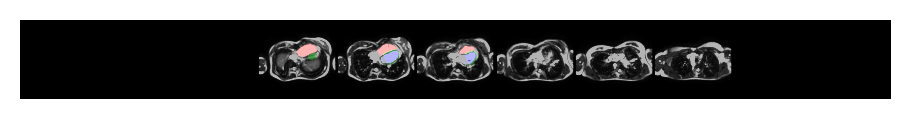

2020-12-18 12:27:29,620 INFO GT on AX


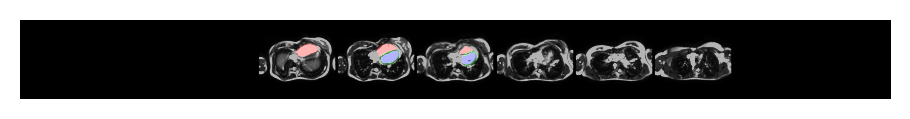

2020-12-18 12:27:30,173 INFO inv mask shape: (24, 256, 256, 4), gt mask shape: (24, 256, 256, 4)
2020-12-18 12:27:30,181 INFO DICE LV: 0.8269640207290649
2020-12-18 12:27:30,188 INFO DICE RV: 0.8720560669898987
2020-12-18 12:27:30,196 INFO DICE MYO: 0.5740272402763367
2020-12-18 12:27:30,196 INFO m: [[ 0.4111  -0.7446  -0.526   -0.9995 ]
 [ 0.3547  -0.401    0.8447  -0.999  ]
 [-0.84    -0.5337   0.09937 16.53   ]]
2020-12-18 12:27:30,197 INFO m_mod: [[ 0.4111  -0.7446  -0.526   -0.5137 ]
 [ 0.3547  -0.401    0.8447  -0.551  ]
 [-0.84    -0.5337   0.09937  1.586  ]]
2020-12-18 12:27:30,198 INFO m_scaled: [[ 0.4111  -0.7446  -0.526   -1.999  ]
 [ 0.3547  -0.401    0.8447  -1.998  ]
 [-0.84    -0.5337   0.09937 33.06   ]]
2020-12-18 12:27:30,199 INFO 0000-0HQQW4ZN_2007-05-23_ES_msk.nrrd
2020-12-18 12:27:35,469 INFO DICE LV: 0.8390822410583496
2020-12-18 12:27:35,588 INFO DICE RV: 0.8388274908065796
2020-12-18 12:27:35,692 INFO DICE MYO: 0.6964806914329529
2020-12-18 12:27:36,252 INFO Pre

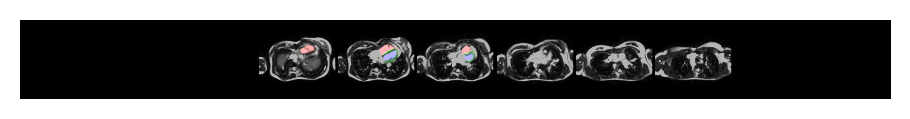

2020-12-18 12:27:36,696 INFO GT on AX


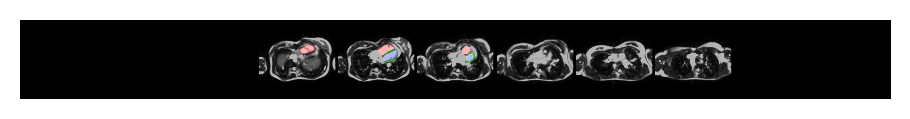

2020-12-18 12:27:37,227 INFO inv mask shape: (24, 256, 256, 4), gt mask shape: (24, 256, 256, 4)
2020-12-18 12:27:37,233 INFO DICE LV: 0.8507001996040344
2020-12-18 12:27:37,239 INFO DICE RV: 0.8437720537185669
2020-12-18 12:27:37,246 INFO DICE MYO: 0.6940122842788696
2020-12-18 12:27:37,247 INFO m: [[ 0.4102 -0.7397 -0.533  -0.9995]
 [ 0.3552 -0.4092  0.8403 -0.9995]
 [-0.8403 -0.534   0.0951 16.62  ]]
2020-12-18 12:27:37,248 INFO m_mod: [[ 0.4102 -0.7397 -0.533  -0.5156]
 [ 0.3552 -0.4092  0.8403 -0.5527]
 [-0.8403 -0.534   0.0951  1.595 ]]
2020-12-18 12:27:37,248 INFO m_scaled: [[ 0.4102 -0.7397 -0.533  -1.999 ]
 [ 0.3552 -0.4092  0.8403 -1.999 ]
 [-0.8403 -0.534   0.0951 33.25  ]]
2020-12-18 12:27:37,250 INFO 0000-13JLP3HN_2007-05-22_ED_msk.nrrd
2020-12-18 12:27:42,492 INFO DICE LV: 0.9239832758903503
2020-12-18 12:27:42,585 INFO DICE RV: 0.822562038898468
2020-12-18 12:27:42,673 INFO DICE MYO: 0.729658842086792
2020-12-18 12:27:43,229 INFO Predicted mask rotated to AX on original 

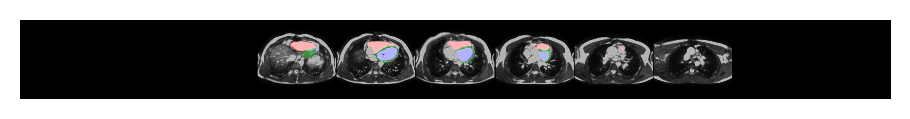

2020-12-18 12:27:43,678 INFO GT on AX


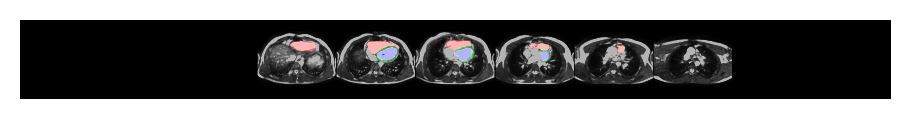

2020-12-18 12:27:44,245 INFO inv mask shape: (22, 352, 352, 4), gt mask shape: (22, 352, 352, 4)
2020-12-18 12:27:44,257 INFO DICE LV: 0.92470782995224
2020-12-18 12:27:44,269 INFO DICE RV: 0.8306406140327454
2020-12-18 12:27:44,282 INFO DICE MYO: 0.7230678200721741
2020-12-18 12:27:44,283 INFO m: [[ 0.4155  -0.773   -0.4795  -0.999  ]
 [ 0.3494  -0.3513   0.8687  -0.999  ]
 [-0.84    -0.529    0.12427 15.95   ]]
2020-12-18 12:27:44,283 INFO m_mod: [[ 0.4155  -0.773   -0.4795  -0.501  ]
 [ 0.3494  -0.3513   0.8687  -0.538  ]
 [-0.84    -0.529    0.12427  1.529  ]]
2020-12-18 12:27:44,284 INFO m_scaled: [[ 0.4155  -0.773   -0.4795  -1.998  ]
 [ 0.3494  -0.3513   0.8687  -1.998  ]
 [-0.84    -0.529    0.12427 31.9    ]]
2020-12-18 12:27:44,285 INFO 0000-13JLP3HN_2007-05-22_ES_msk.nrrd
2020-12-18 12:27:50,947 INFO DICE LV: 0.8601808547973633
2020-12-18 12:27:51,037 INFO DICE RV: 0.7165586948394775
2020-12-18 12:27:51,126 INFO DICE MYO: 0.7541986107826233
2020-12-18 12:27:51,669 INFO Predi

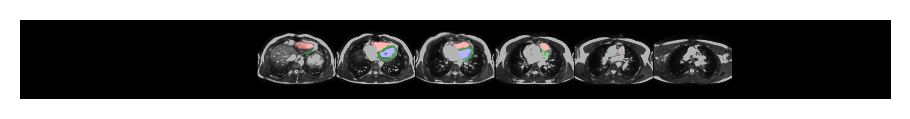

2020-12-18 12:27:52,120 INFO GT on AX


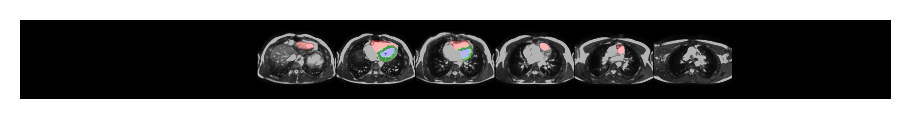

2020-12-18 12:27:52,647 INFO inv mask shape: (22, 352, 352, 4), gt mask shape: (22, 352, 352, 4)
2020-12-18 12:27:52,658 INFO DICE LV: 0.8554379343986511
2020-12-18 12:27:52,668 INFO DICE RV: 0.7280399203300476
2020-12-18 12:27:52,678 INFO DICE MYO: 0.754951536655426
2020-12-18 12:27:52,678 INFO m: [[ 0.416  -0.7744 -0.4773 -0.999 ]
 [ 0.349  -0.3489  0.87   -0.999 ]
 [-0.84   -0.5283  0.1254 15.94  ]]
2020-12-18 12:27:52,679 INFO m_mod: [[ 0.416  -0.7744 -0.4773 -0.501 ]
 [ 0.349  -0.3489  0.87   -0.5376]
 [-0.84   -0.5283  0.1254  1.528 ]]
2020-12-18 12:27:52,680 INFO m_scaled: [[ 0.416  -0.7744 -0.4773 -1.998 ]
 [ 0.349  -0.3489  0.87   -1.998 ]
 [-0.84   -0.5283  0.1254 31.88  ]]
2020-12-18 12:27:52,681 INFO 0000-24YLF77L_2007-11-19_ED_msk.nrrd
2020-12-18 12:27:58,078 INFO DICE LV: 0.9122151732444763
2020-12-18 12:27:58,160 INFO DICE RV: 0.8571963906288147
2020-12-18 12:27:58,240 INFO DICE MYO: 0.6861162781715393
2020-12-18 12:27:58,803 INFO Predicted mask rotated to AX on original

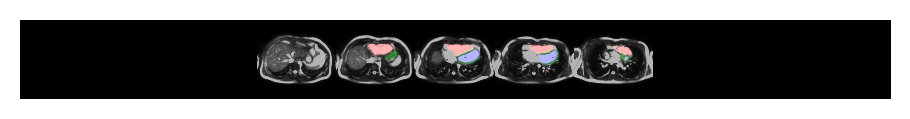

2020-12-18 12:27:59,260 INFO GT on AX


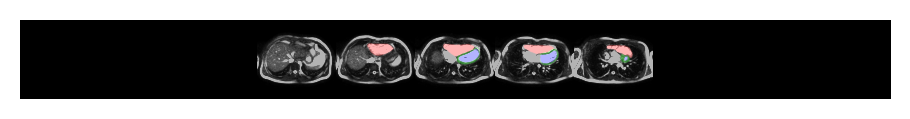

2020-12-18 12:27:59,739 INFO inv mask shape: (19, 256, 256, 4), gt mask shape: (19, 256, 256, 4)
2020-12-18 12:27:59,745 INFO DICE LV: 0.9135816693305969
2020-12-18 12:27:59,751 INFO DICE RV: 0.8553265333175659
2020-12-18 12:27:59,756 INFO DICE MYO: 0.700234055519104
2020-12-18 12:27:59,757 INFO m: [[ 0.412  -0.751  -0.516  -0.9995]
 [ 0.3535 -0.3904  0.85   -0.999 ]
 [-0.84   -0.5327  0.1046 16.4   ]]
2020-12-18 12:27:59,757 INFO m_mod: [[ 0.412  -0.751  -0.516  -0.511 ]
 [ 0.3535 -0.3904  0.85   -0.548 ]
 [-0.84   -0.5327  0.1046  1.573 ]]
2020-12-18 12:27:59,758 INFO m_scaled: [[ 0.412  -0.751  -0.516  -1.999 ]
 [ 0.3535 -0.3904  0.85   -1.998 ]
 [-0.84   -0.5327  0.1046 32.8   ]]
2020-12-18 12:27:59,759 INFO 0000-24YLF77L_2007-11-19_ES_msk.nrrd
2020-12-18 12:28:05,104 INFO DICE LV: 0.85751873254776
2020-12-18 12:28:05,186 INFO DICE RV: 0.8179322481155396
2020-12-18 12:28:05,268 INFO DICE MYO: 0.7564550638198853
2020-12-18 12:28:05,797 INFO Predicted mask rotated to AX on original A

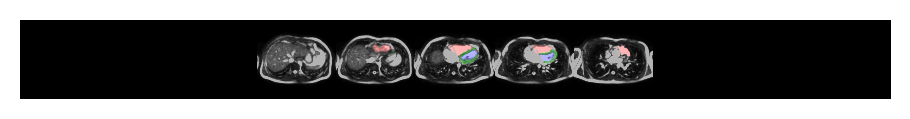

2020-12-18 12:28:06,256 INFO GT on AX


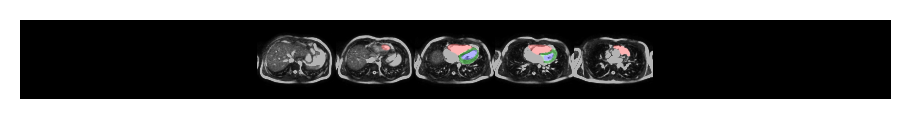

2020-12-18 12:28:06,744 INFO inv mask shape: (19, 256, 256, 4), gt mask shape: (19, 256, 256, 4)
2020-12-18 12:28:06,752 INFO DICE LV: 0.8633855581283569
2020-12-18 12:28:06,758 INFO DICE RV: 0.8287683129310608
2020-12-18 12:28:06,763 INFO DICE MYO: 0.7527777552604675
2020-12-18 12:28:06,764 INFO m: [[ 0.4116 -0.749  -0.519  -0.9995]
 [ 0.354  -0.3938  0.8486 -0.999 ]
 [-0.84   -0.533   0.103  16.45  ]]
2020-12-18 12:28:06,765 INFO m_mod: [[ 0.4116 -0.749  -0.519  -0.512 ]
 [ 0.354  -0.3938  0.8486 -0.5493]
 [-0.84   -0.533   0.103   1.578 ]]
2020-12-18 12:28:06,765 INFO m_scaled: [[ 0.4116 -0.749  -0.519  -1.999 ]
 [ 0.354  -0.3938  0.8486 -1.998 ]
 [-0.84   -0.533   0.103  32.9   ]]
2020-12-18 12:28:06,766 INFO 0000-2CVUG1C5_2006-09-06_ED_msk.nrrd
2020-12-18 12:28:12,029 INFO DICE LV: 0.788373589515686
2020-12-18 12:28:12,122 INFO DICE RV: 0.8496838212013245
2020-12-18 12:28:12,210 INFO DICE MYO: 0.5629212856292725
2020-12-18 12:28:12,784 INFO Predicted mask rotated to AX on original

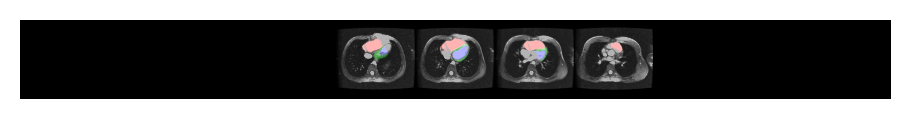

2020-12-18 12:28:13,247 INFO GT on AX


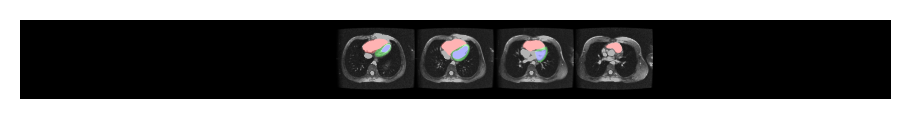

2020-12-18 12:28:13,791 INFO inv mask shape: (14, 512, 512, 4), gt mask shape: (14, 512, 512, 4)
2020-12-18 12:28:13,804 INFO DICE LV: 0.791684091091156
2020-12-18 12:28:13,817 INFO DICE RV: 0.8586956262588501
2020-12-18 12:28:13,831 INFO DICE MYO: 0.5682282447814941
2020-12-18 12:28:13,831 INFO m: [[ 0.4072 -0.7197 -0.5625 -0.9995]
 [ 0.3584 -0.441   0.823  -0.9995]
 [-0.8403 -0.537   0.0784 17.02  ]]
2020-12-18 12:28:13,832 INFO m_mod: [[ 0.4072 -0.7197 -0.5625 -0.524 ]
 [ 0.3584 -0.441   0.823  -0.5615]
 [-0.8403 -0.537   0.0784  1.632 ]]
2020-12-18 12:28:13,832 INFO m_scaled: [[ 0.4072 -0.7197 -0.5625 -1.999 ]
 [ 0.3584 -0.441   0.823  -1.999 ]
 [-0.8403 -0.537   0.0784 34.03  ]]
2020-12-18 12:28:13,833 INFO 0000-2CVUG1C5_2006-09-06_ES_msk.nrrd
2020-12-18 12:28:19,052 INFO DICE LV: 0.5378254055976868
2020-12-18 12:28:19,150 INFO DICE RV: 0.6218549013137817
2020-12-18 12:28:19,253 INFO DICE MYO: 0.4004894495010376
2020-12-18 12:28:19,854 INFO Predicted mask rotated to AX on original

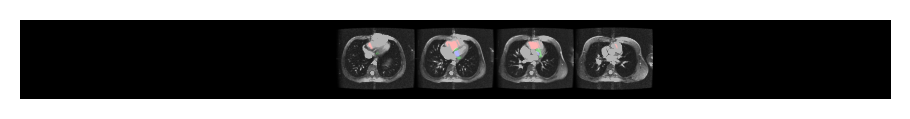

2020-12-18 12:28:20,295 INFO GT on AX


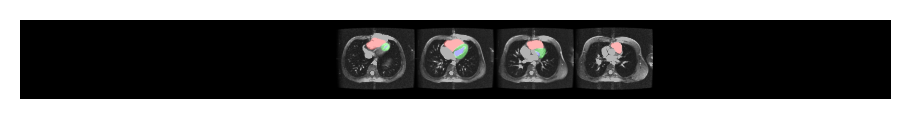

2020-12-18 12:28:20,830 INFO inv mask shape: (14, 512, 512, 4), gt mask shape: (14, 512, 512, 4)
2020-12-18 12:28:20,844 INFO DICE LV: 0.48744630813598633
2020-12-18 12:28:20,856 INFO DICE RV: 0.598557710647583
2020-12-18 12:28:20,869 INFO DICE MYO: 0.2632557451725006
2020-12-18 12:28:20,869 INFO m: [[ 0.4084  -0.729   -0.5493  -0.9995 ]
 [ 0.3572  -0.4263   0.831   -0.9995 ]
 [-0.8403  -0.5356   0.08624 16.83   ]]
2020-12-18 12:28:20,870 INFO m_mod: [[ 0.4084  -0.729   -0.5493  -0.52   ]
 [ 0.3572  -0.4263   0.831   -0.5576 ]
 [-0.8403  -0.5356   0.08624  1.614  ]]
2020-12-18 12:28:20,871 INFO m_scaled: [[ 0.4084  -0.729   -0.5493  -1.999  ]
 [ 0.3572  -0.4263   0.831   -1.999  ]
 [-0.8403  -0.5356   0.08624 33.66   ]]
2020-12-18 12:28:20,872 INFO 0000-2CW0G1A5_2006-04-06_ED_msk.nrrd
2020-12-18 12:28:26,127 INFO DICE LV: 0.8945156931877136
2020-12-18 12:28:26,223 INFO DICE RV: 0.8959599137306213
2020-12-18 12:28:26,324 INFO DICE MYO: 0.6614753603935242
2020-12-18 12:28:26,901 INFO Pre

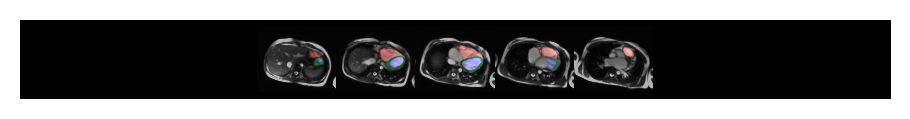

2020-12-18 12:28:27,367 INFO GT on AX


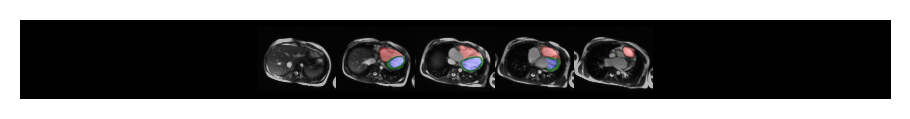

2020-12-18 12:28:27,820 INFO inv mask shape: (18, 156, 192, 4), gt mask shape: (18, 156, 192, 4)
2020-12-18 12:28:27,824 INFO DICE LV: 0.8952353596687317
2020-12-18 12:28:27,826 INFO DICE RV: 0.8940640091896057
2020-12-18 12:28:27,829 INFO DICE MYO: 0.6609373092651367
2020-12-18 12:28:27,830 INFO m: [[ 0.4043  -0.701   -0.587   -0.9995 ]
 [ 0.3606  -0.467    0.807   -0.9995 ]
 [-0.8403  -0.538    0.06415 17.34   ]]
2020-12-18 12:28:27,830 INFO m_mod: [[ 0.4043  -0.701   -0.587   -0.5303 ]
 [ 0.3606  -0.467    0.807   -0.5684 ]
 [-0.8403  -0.538    0.06415  1.663  ]]
2020-12-18 12:28:27,831 INFO m_scaled: [[ 0.4043  -0.701   -0.587   -1.999  ]
 [ 0.3606  -0.467    0.807   -1.999  ]
 [-0.8403  -0.538    0.06415 34.7    ]]
2020-12-18 12:28:27,832 INFO 0000-2CW0G1A5_2006-04-06_ES_msk.nrrd
2020-12-18 12:28:33,200 INFO DICE LV: 0.8914738297462463
2020-12-18 12:28:33,299 INFO DICE RV: 0.7948659062385559
2020-12-18 12:28:33,395 INFO DICE MYO: 0.7338463068008423
2020-12-18 12:28:33,960 INFO Pre

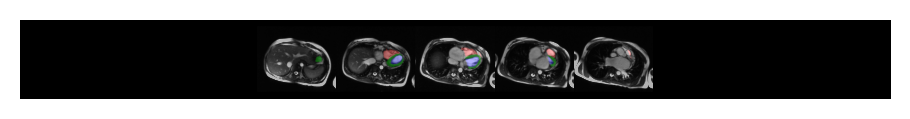

2020-12-18 12:28:34,437 INFO GT on AX


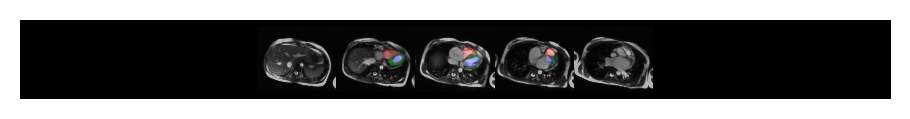

2020-12-18 12:28:34,896 INFO inv mask shape: (18, 156, 192, 4), gt mask shape: (18, 156, 192, 4)
2020-12-18 12:28:34,899 INFO DICE LV: 0.8902183771133423
2020-12-18 12:28:34,902 INFO DICE RV: 0.80031418800354
2020-12-18 12:28:34,905 INFO DICE MYO: 0.7170194983482361
2020-12-18 12:28:34,906 INFO m: [[ 0.404   -0.6987  -0.5903  -0.9995 ]
 [ 0.3613  -0.4712   0.805   -0.9995 ]
 [-0.8403  -0.5386   0.06207 17.39   ]]
2020-12-18 12:28:34,907 INFO m_mod: [[ 0.404   -0.6987  -0.5903  -0.5312 ]
 [ 0.3613  -0.4712   0.805   -0.5693 ]
 [-0.8403  -0.5386   0.06207  1.668  ]]
2020-12-18 12:28:34,907 INFO m_scaled: [[ 0.404   -0.6987  -0.5903  -1.999  ]
 [ 0.3613  -0.4712   0.805   -1.999  ]
 [-0.8403  -0.5386   0.06207 34.78   ]]
2020-12-18 12:28:34,908 INFO 0000-2XRR719Z_2005-05-02_ED_msk.nrrd
2020-12-18 12:28:40,276 INFO DICE LV: 0.9242702126502991
2020-12-18 12:28:40,373 INFO DICE RV: 0.8888436555862427
2020-12-18 12:28:40,476 INFO DICE MYO: 0.6470198035240173
2020-12-18 12:28:41,025 INFO Predi

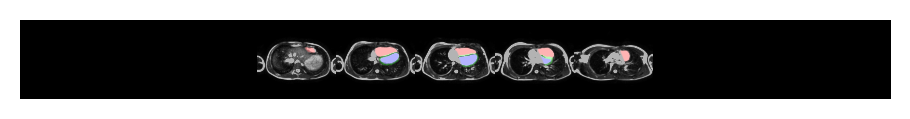

2020-12-18 12:28:41,470 INFO GT on AX


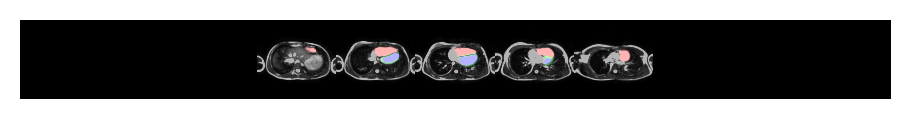

2020-12-18 12:28:41,986 INFO inv mask shape: (18, 256, 256, 4), gt mask shape: (18, 256, 256, 4)
2020-12-18 12:28:41,992 INFO DICE LV: 0.9366111755371094
2020-12-18 12:28:41,998 INFO DICE RV: 0.8900256156921387
2020-12-18 12:28:42,003 INFO DICE MYO: 0.6633995771408081
2020-12-18 12:28:42,004 INFO m: [[ 0.4116  -0.7485  -0.5205  -0.9995 ]
 [ 0.3542  -0.3948   0.848   -0.999  ]
 [-0.84    -0.533    0.10254 16.47   ]]
2020-12-18 12:28:42,004 INFO m_mod: [[ 0.4116  -0.7485  -0.5205  -0.5127 ]
 [ 0.3542  -0.3948   0.848   -0.55   ]
 [-0.84    -0.533    0.10254  1.579  ]]
2020-12-18 12:28:42,005 INFO m_scaled: [[ 0.4116  -0.7485  -0.5205  -1.999  ]
 [ 0.3542  -0.3948   0.848   -1.998  ]
 [-0.84    -0.533    0.10254 32.94   ]]
2020-12-18 12:28:42,006 INFO 0000-2XRR719Z_2005-05-02_ES_msk.nrrd
2020-12-18 12:28:47,315 INFO DICE LV: 0.8436023592948914
2020-12-18 12:28:47,407 INFO DICE RV: 0.8387740254402161
2020-12-18 12:28:47,494 INFO DICE MYO: 0.7072040438652039
2020-12-18 12:28:48,055 INFO Pre

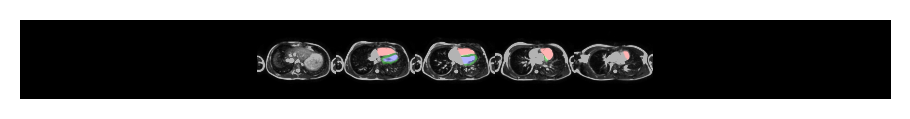

2020-12-18 12:28:48,500 INFO GT on AX


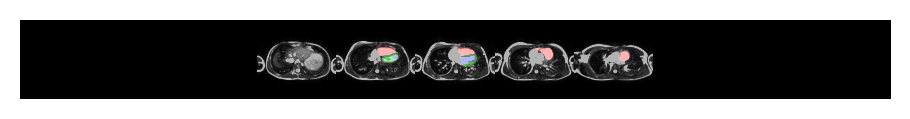

2020-12-18 12:28:49,017 INFO inv mask shape: (18, 256, 256, 4), gt mask shape: (18, 256, 256, 4)
2020-12-18 12:28:49,023 INFO DICE LV: 0.8623523712158203
2020-12-18 12:28:49,028 INFO DICE RV: 0.8446055054664612
2020-12-18 12:28:49,034 INFO DICE MYO: 0.7417525053024292
2020-12-18 12:28:49,035 INFO m: [[ 0.412  -0.751  -0.515  -0.9995]
 [ 0.3535 -0.3892  0.85   -0.999 ]
 [-0.84   -0.5327  0.1051 16.39  ]]
2020-12-18 12:28:49,035 INFO m_mod: [[ 0.412  -0.751  -0.515  -0.5107]
 [ 0.3535 -0.3892  0.85   -0.548 ]
 [-0.84   -0.5327  0.1051  1.572 ]]
2020-12-18 12:28:49,036 INFO m_scaled: [[ 0.412  -0.751  -0.515  -1.999 ]
 [ 0.3535 -0.3892  0.85   -1.998 ]
 [-0.84   -0.5327  0.1051 32.78  ]]
2020-12-18 12:28:49,037 INFO 0000-3EX293QC_2006-06-19_ED_msk.nrrd
2020-12-18 12:28:54,358 INFO DICE LV: 0.9229387640953064
2020-12-18 12:28:54,454 INFO DICE RV: 0.8818545937538147
2020-12-18 12:28:54,540 INFO DICE MYO: 0.7221869826316833
2020-12-18 12:28:55,099 INFO Predicted mask rotated to AX on origina

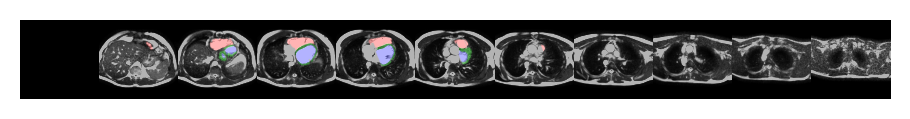

2020-12-18 12:28:55,558 INFO GT on AX


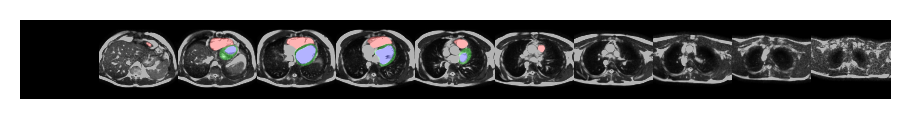

2020-12-18 12:28:56,198 INFO inv mask shape: (38, 256, 256, 4), gt mask shape: (38, 256, 256, 4)
2020-12-18 12:28:56,208 INFO DICE LV: 0.9278627634048462
2020-12-18 12:28:56,218 INFO DICE RV: 0.8818525075912476
2020-12-18 12:28:56,228 INFO DICE MYO: 0.7316221594810486
2020-12-18 12:28:56,228 INFO m: [[ 0.424  -0.812  -0.4016 -0.999 ]
 [ 0.3416 -0.267   0.9014 -0.9985]
 [-0.839  -0.519   0.1641 15.06  ]]
2020-12-18 12:28:56,229 INFO m_mod: [[ 0.424  -0.812  -0.4016 -0.4814]
 [ 0.3416 -0.267   0.9014 -0.5176]
 [-0.839  -0.519   0.1641  1.444 ]]
2020-12-18 12:28:56,229 INFO m_scaled: [[ 0.424  -0.812  -0.4016 -1.998 ]
 [ 0.3416 -0.267   0.9014 -1.997 ]
 [-0.839  -0.519   0.1641 30.12  ]]
2020-12-18 12:28:56,231 INFO 0000-3EX293QC_2006-06-19_ES_msk.nrrd
2020-12-18 12:29:01,590 INFO DICE LV: 0.8519630432128906
2020-12-18 12:29:01,679 INFO DICE RV: 0.7350874543190002
2020-12-18 12:29:01,766 INFO DICE MYO: 0.6489158272743225
2020-12-18 12:29:02,300 INFO Predicted mask rotated to AX on origina

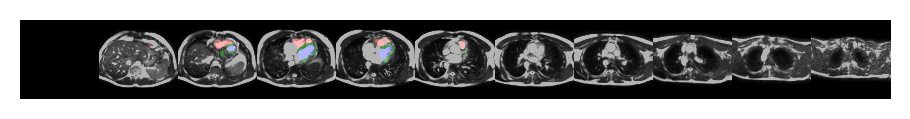

2020-12-18 12:29:03,919 INFO GT on AX


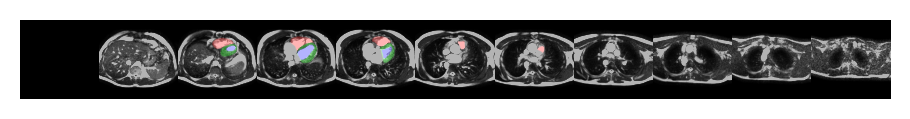

2020-12-18 12:29:04,466 INFO inv mask shape: (38, 256, 256, 4), gt mask shape: (38, 256, 256, 4)
2020-12-18 12:29:04,478 INFO DICE LV: 0.854575514793396
2020-12-18 12:29:04,488 INFO DICE RV: 0.7332027554512024
2020-12-18 12:29:04,500 INFO DICE MYO: 0.6574208736419678
2020-12-18 12:29:04,501 INFO m: [[ 0.4246 -0.815  -0.3962 -0.999 ]
 [ 0.341  -0.2617  0.9033 -0.9985]
 [-0.839  -0.5186  0.1666 15.01  ]]
2020-12-18 12:29:04,501 INFO m_mod: [[ 0.4246 -0.815  -0.3962 -0.48  ]
 [ 0.341  -0.2617  0.9033 -0.5166]
 [-0.839  -0.5186  0.1666  1.439 ]]
2020-12-18 12:29:04,502 INFO m_scaled: [[ 0.4246 -0.815  -0.3962 -1.998 ]
 [ 0.341  -0.2617  0.9033 -1.997 ]
 [-0.839  -0.5186  0.1666 30.02  ]]
2020-12-18 12:29:04,503 INFO 0000-5RMHZGWP_2006-08-03_ED_msk.nrrd
2020-12-18 12:29:10,023 INFO DICE LV: 0.8712182641029358
2020-12-18 12:29:10,102 INFO DICE RV: 0.6972954869270325
2020-12-18 12:29:10,175 INFO DICE MYO: 0.6302832961082458
2020-12-18 12:29:10,719 INFO Predicted mask rotated to AX on original

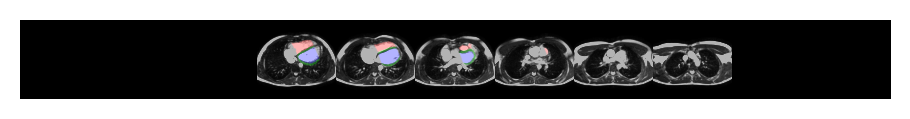

2020-12-18 12:29:11,167 INFO GT on AX


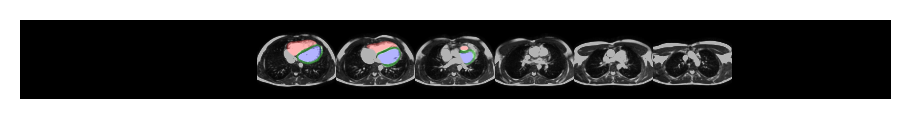

2020-12-18 12:29:11,667 INFO inv mask shape: (24, 256, 256, 4), gt mask shape: (24, 256, 256, 4)
2020-12-18 12:29:11,674 INFO DICE LV: 0.8693128228187561
2020-12-18 12:29:11,682 INFO DICE RV: 0.6807662844657898
2020-12-18 12:29:11,689 INFO DICE MYO: 0.6506030559539795
2020-12-18 12:29:11,690 INFO m: [[ 0.4116  -0.7485  -0.5205  -0.9995 ]
 [ 0.3542  -0.3948   0.848   -0.999  ]
 [-0.84    -0.533    0.10254 16.47   ]]
2020-12-18 12:29:11,690 INFO m_mod: [[ 0.4116  -0.7485  -0.5205  -0.512  ]
 [ 0.3542  -0.3948   0.848   -0.55   ]
 [-0.84    -0.533    0.10254  1.579  ]]
2020-12-18 12:29:11,691 INFO m_scaled: [[ 0.4116  -0.7485  -0.5205  -1.999  ]
 [ 0.3542  -0.3948   0.848   -1.998  ]
 [-0.84    -0.533    0.10254 32.94   ]]
2020-12-18 12:29:11,691 INFO 0000-5RMHZGWP_2006-08-03_ES_msk.nrrd
2020-12-18 12:29:17,978 INFO DICE LV: 0.8124809861183167
2020-12-18 12:29:18,055 INFO DICE RV: 0.6699528098106384
2020-12-18 12:29:18,129 INFO DICE MYO: 0.6223104596138
2020-12-18 12:29:18,658 INFO Predic

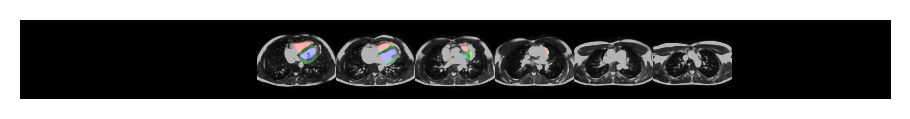

2020-12-18 12:29:19,105 INFO GT on AX


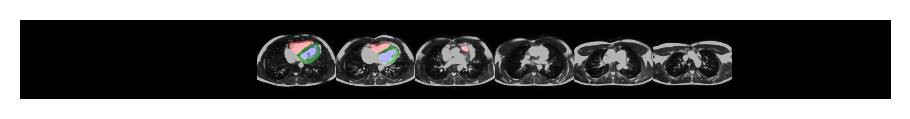

2020-12-18 12:29:19,607 INFO inv mask shape: (24, 256, 256, 4), gt mask shape: (24, 256, 256, 4)
2020-12-18 12:29:19,614 INFO DICE LV: 0.8106158971786499
2020-12-18 12:29:19,620 INFO DICE RV: 0.659591555595398
2020-12-18 12:29:19,626 INFO DICE MYO: 0.6200499534606934
2020-12-18 12:29:19,627 INFO m: [[ 0.4136  -0.7603  -0.501   -0.9995 ]
 [ 0.3518  -0.3738   0.858   -0.999  ]
 [-0.84    -0.5312   0.11285 16.23   ]]
2020-12-18 12:29:19,628 INFO m_mod: [[ 0.4136  -0.7603  -0.501   -0.5073 ]
 [ 0.3518  -0.3738   0.858   -0.5444 ]
 [-0.84    -0.5312   0.11285  1.557  ]]
2020-12-18 12:29:19,628 INFO m_scaled: [[ 0.4136  -0.7603  -0.501   -1.999  ]
 [ 0.3518  -0.3738   0.858   -1.998  ]
 [-0.84    -0.5312   0.11285 32.47   ]]
2020-12-18 12:29:19,629 INFO 0000-5W8RFCJD_2005-04-18_ED_msk.nrrd
2020-12-18 12:29:24,864 INFO DICE LV: 0.7668336629867554
2020-12-18 12:29:24,938 INFO DICE RV: 0.7323410511016846
2020-12-18 12:29:25,010 INFO DICE MYO: 0.47018638253211975
2020-12-18 12:29:25,529 INFO Pre

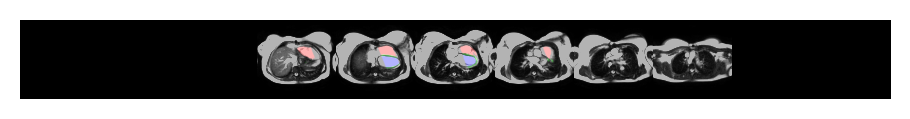

2020-12-18 12:29:25,974 INFO GT on AX


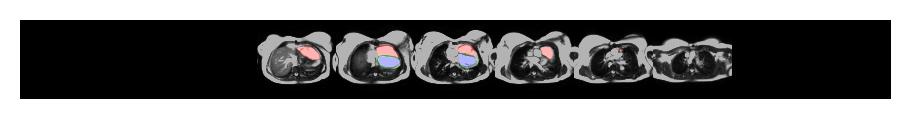

2020-12-18 12:29:26,453 INFO inv mask shape: (16, 256, 256, 4), gt mask shape: (16, 256, 256, 4)
2020-12-18 12:29:26,458 INFO DICE LV: 0.7768330574035645
2020-12-18 12:29:26,463 INFO DICE RV: 0.7413588166236877
2020-12-18 12:29:26,467 INFO DICE MYO: 0.5
2020-12-18 12:29:26,468 INFO m: [[ 0.4285 -0.8286 -0.3591 -0.9985]
 [ 0.3367 -0.2222  0.915  -0.998 ]
 [-0.8384 -0.513   0.1838 14.555 ]]
2020-12-18 12:29:26,468 INFO m_mod: [[ 0.4285 -0.8286 -0.3591 -0.4697]
 [ 0.3367 -0.2222  0.915  -0.506 ]
 [-0.8384 -0.513   0.1838  1.3955]]
2020-12-18 12:29:26,469 INFO m_scaled: [[ 0.4285 -0.8286 -0.3591 -1.997 ]
 [ 0.3367 -0.2222  0.915  -1.996 ]
 [-0.8384 -0.513   0.1838 29.11  ]]
2020-12-18 12:29:26,469 INFO 0000-5W8RFCJD_2005-04-18_ES_msk.nrrd
2020-12-18 12:29:31,677 INFO DICE LV: 0.7391493916511536
2020-12-18 12:29:31,751 INFO DICE RV: 0.5791263580322266
2020-12-18 12:29:31,823 INFO DICE MYO: 0.49780309200286865
2020-12-18 12:29:32,338 INFO Predicted mask rotated to AX on original AX image


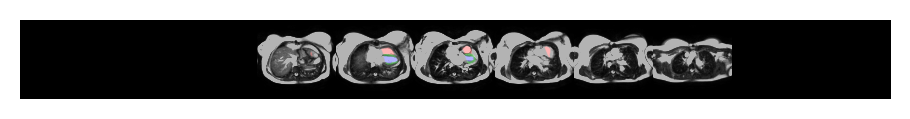

2020-12-18 12:29:32,785 INFO GT on AX


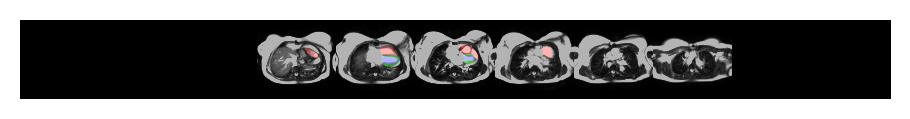

2020-12-18 12:29:33,267 INFO inv mask shape: (16, 256, 256, 4), gt mask shape: (16, 256, 256, 4)
2020-12-18 12:29:33,272 INFO DICE LV: 0.7583798766136169
2020-12-18 12:29:33,276 INFO DICE RV: 0.5799508094787598
2020-12-18 12:29:33,281 INFO DICE MYO: 0.4836196303367615
2020-12-18 12:29:33,281 INFO m: [[ 0.427  -0.823  -0.3733 -0.9985]
 [ 0.3384 -0.2372  0.91   -0.9985]
 [-0.8384 -0.515   0.1774 14.7   ]]
2020-12-18 12:29:33,282 INFO m_mod: [[ 0.427  -0.823  -0.3733 -0.4731]
 [ 0.3384 -0.2372  0.91   -0.5093]
 [-0.8384 -0.515   0.1774  1.409 ]]
2020-12-18 12:29:33,283 INFO m_scaled: [[ 0.427  -0.823  -0.3733 -1.997 ]
 [ 0.3384 -0.2372  0.91   -1.997 ]
 [-0.8384 -0.515   0.1774 29.4   ]]
2020-12-18 12:29:33,283 INFO 0000-DLTVKE94_2006-07-18_ED_msk.nrrd
2020-12-18 12:29:38,546 INFO DICE LV: 0.9055507183074951
2020-12-18 12:29:38,624 INFO DICE RV: 0.8202937841415405
2020-12-18 12:29:38,697 INFO DICE MYO: 0.632204532623291
2020-12-18 12:29:39,211 INFO Predicted mask rotated to AX on original

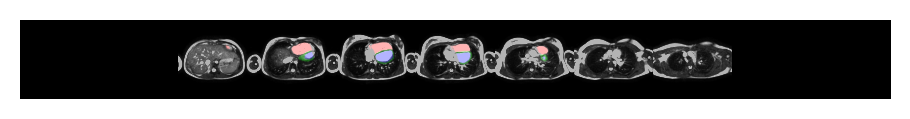

2020-12-18 12:29:39,657 INFO GT on AX


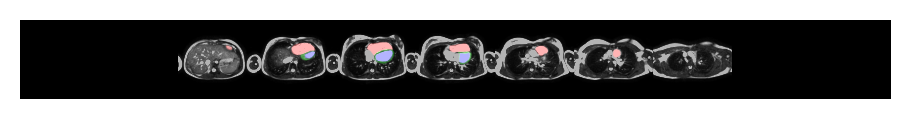

2020-12-18 12:29:40,162 INFO inv mask shape: (28, 256, 256, 4), gt mask shape: (28, 256, 256, 4)
2020-12-18 12:29:40,171 INFO DICE LV: 0.9102484583854675
2020-12-18 12:29:40,180 INFO DICE RV: 0.822076141834259
2020-12-18 12:29:40,188 INFO DICE MYO: 0.6399443745613098
2020-12-18 12:29:40,188 INFO m: [[ 0.417  -0.7812 -0.4653 -0.999 ]
 [ 0.348  -0.336   0.8755 -0.999 ]
 [-0.84   -0.527   0.1315 15.805 ]]
2020-12-18 12:29:40,189 INFO m_mod: [[ 0.417  -0.7812 -0.4653 -0.498 ]
 [ 0.348  -0.336   0.8755 -0.5347]
 [-0.84   -0.527   0.1315  1.516 ]]
2020-12-18 12:29:40,190 INFO m_scaled: [[ 0.417  -0.7812 -0.4653 -1.998 ]
 [ 0.348  -0.336   0.8755 -1.998 ]
 [-0.84   -0.527   0.1315 31.61  ]]
2020-12-18 12:29:40,190 INFO 0000-DLTVKE94_2006-07-18_ES_msk.nrrd
2020-12-18 12:29:45,447 INFO DICE LV: 0.7959176898002625
2020-12-18 12:29:45,522 INFO DICE RV: 0.7041395306587219
2020-12-18 12:29:45,594 INFO DICE MYO: 0.6915131211280823
2020-12-18 12:29:46,121 INFO Predicted mask rotated to AX on original

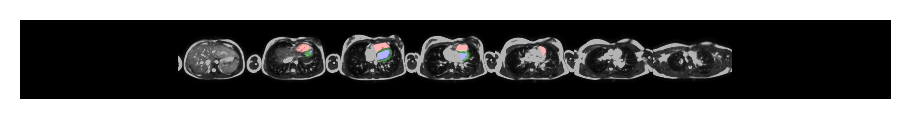

2020-12-18 12:29:46,570 INFO GT on AX


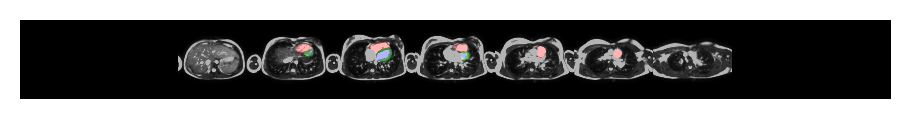

2020-12-18 12:29:47,081 INFO inv mask shape: (28, 256, 256, 4), gt mask shape: (28, 256, 256, 4)
2020-12-18 12:29:47,089 INFO DICE LV: 0.7986674308776855
2020-12-18 12:29:47,096 INFO DICE RV: 0.7064390778541565
2020-12-18 12:29:47,103 INFO DICE MYO: 0.6994426846504211
2020-12-18 12:29:47,103 INFO m: [[ 0.418  -0.7847 -0.4578 -0.999 ]
 [ 0.3474 -0.3271  0.8784 -0.999 ]
 [-0.8394 -0.5264  0.1357 15.71  ]]
2020-12-18 12:29:47,104 INFO m_mod: [[ 0.418  -0.7847 -0.4578 -0.496 ]
 [ 0.3474 -0.3271  0.8784 -0.5327]
 [-0.8394 -0.5264  0.1357  1.506 ]]
2020-12-18 12:29:47,104 INFO m_scaled: [[ 0.418  -0.7847 -0.4578 -1.998 ]
 [ 0.3474 -0.3271  0.8784 -1.998 ]
 [-0.8394 -0.5264  0.1357 31.42  ]]
2020-12-18 12:29:47,105 INFO 0000-E0RJZQQM_2005-09-30_ED_msk.nrrd
2020-12-18 12:29:52,338 INFO DICE LV: 0.8710859417915344
2020-12-18 12:29:52,417 INFO DICE RV: 0.7400360703468323
2020-12-18 12:29:52,490 INFO DICE MYO: 0.6028913855552673
2020-12-18 12:29:53,031 INFO Predicted mask rotated to AX on origina

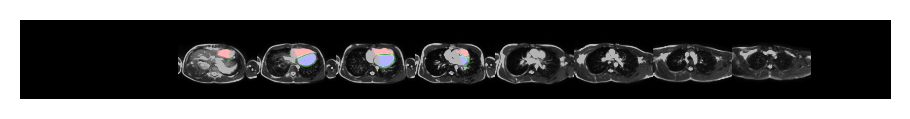

2020-12-18 12:29:53,478 INFO GT on AX


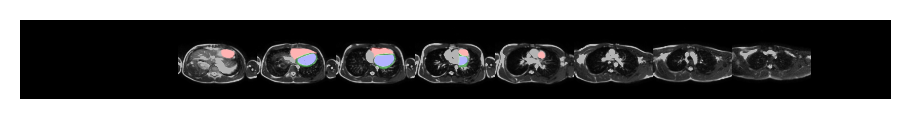

2020-12-18 12:29:53,983 INFO inv mask shape: (22, 256, 256, 4), gt mask shape: (22, 256, 256, 4)
2020-12-18 12:29:53,991 INFO DICE LV: 0.8769221901893616
2020-12-18 12:29:53,997 INFO DICE RV: 0.742735743522644
2020-12-18 12:29:54,004 INFO DICE MYO: 0.6386010646820068
2020-12-18 12:29:54,005 INFO m: [[ 0.4138 -0.7627 -0.4973 -0.9995]
 [ 0.3516 -0.37    0.8604 -0.999 ]
 [-0.84   -0.531   0.115  16.17  ]]
2020-12-18 12:29:54,005 INFO m_mod: [[ 0.4138 -0.7627 -0.4973 -0.506 ]
 [ 0.3516 -0.37    0.8604 -0.543 ]
 [-0.84   -0.531   0.115   1.551 ]]
2020-12-18 12:29:54,006 INFO m_scaled: [[ 0.4138 -0.7627 -0.4973 -1.999 ]
 [ 0.3516 -0.37    0.8604 -1.998 ]
 [-0.84   -0.531   0.115  32.34  ]]
2020-12-18 12:29:54,007 INFO 0000-E0RJZQQM_2005-09-30_ES_msk.nrrd
2020-12-18 12:29:59,368 INFO DICE LV: 0.8187649846076965
2020-12-18 12:29:59,449 INFO DICE RV: 0.5264357328414917
2020-12-18 12:29:59,528 INFO DICE MYO: 0.6205112338066101
2020-12-18 12:30:00,095 INFO Predicted mask rotated to AX on original

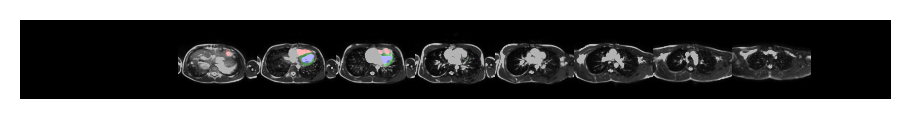

2020-12-18 12:30:00,538 INFO GT on AX


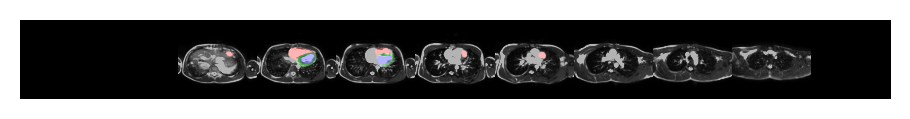

2020-12-18 12:30:01,045 INFO inv mask shape: (22, 256, 256, 4), gt mask shape: (22, 256, 256, 4)
2020-12-18 12:30:01,052 INFO DICE LV: 0.8298982977867126
2020-12-18 12:30:01,058 INFO DICE RV: 0.5351083278656006
2020-12-18 12:30:01,064 INFO DICE MYO: 0.6404919624328613
2020-12-18 12:30:01,065 INFO m: [[ 0.413  -0.759  -0.5034 -0.9995]
 [ 0.3523 -0.3765  0.857  -0.999 ]
 [-0.84   -0.5312  0.1119 16.27  ]]
2020-12-18 12:30:01,065 INFO m_mod: [[ 0.413  -0.759  -0.5034 -0.508 ]
 [ 0.3523 -0.3765  0.857  -0.545 ]
 [-0.84   -0.5312  0.1119  1.56  ]]
2020-12-18 12:30:01,066 INFO m_scaled: [[ 0.413  -0.759  -0.5034 -1.999 ]
 [ 0.3523 -0.3765  0.857  -1.998 ]
 [-0.84   -0.5312  0.1119 32.53  ]]
2020-12-18 12:30:01,066 INFO 0000-E24LRCWD_2006-11-23_ED_msk.nrrd
2020-12-18 12:30:06,339 INFO DICE LV: 0.8932994604110718
2020-12-18 12:30:06,438 INFO DICE RV: 0.8490052819252014
2020-12-18 12:30:06,533 INFO DICE MYO: 0.6581956744194031
2020-12-18 12:30:07,094 INFO Predicted mask rotated to AX on origina

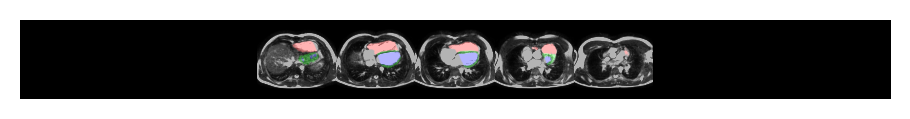

2020-12-18 12:30:07,545 INFO GT on AX


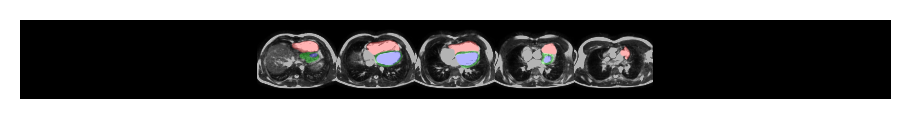

2020-12-18 12:30:08,049 INFO inv mask shape: (20, 256, 256, 4), gt mask shape: (20, 256, 256, 4)
2020-12-18 12:30:08,056 INFO DICE LV: 0.9047309160232544
2020-12-18 12:30:08,061 INFO DICE RV: 0.8599276542663574
2020-12-18 12:30:08,068 INFO DICE MYO: 0.6723645329475403
2020-12-18 12:30:08,068 INFO m: [[ 0.417  -0.7817 -0.4646 -0.999 ]
 [ 0.348  -0.3352  0.876  -0.999 ]
 [-0.84   -0.527   0.1321 15.8   ]]
2020-12-18 12:30:08,069 INFO m_mod: [[ 0.417  -0.7817 -0.4646 -0.498 ]
 [ 0.348  -0.3352  0.876  -0.534 ]
 [-0.84   -0.527   0.1321  1.515 ]]
2020-12-18 12:30:08,069 INFO m_scaled: [[ 0.417  -0.7817 -0.4646 -1.998 ]
 [ 0.348  -0.3352  0.876  -1.998 ]
 [-0.84   -0.527   0.1321 31.6   ]]
2020-12-18 12:30:08,070 INFO 0000-E24LRCWD_2006-11-23_ES_msk.nrrd
2020-12-18 12:30:13,320 INFO DICE LV: 0.8333150744438171
2020-12-18 12:30:13,416 INFO DICE RV: 0.8267426490783691
2020-12-18 12:30:13,505 INFO DICE MYO: 0.6253604888916016
2020-12-18 12:30:14,126 INFO Predicted mask rotated to AX on origina

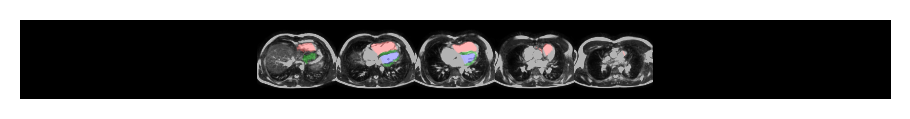

2020-12-18 12:30:14,585 INFO GT on AX


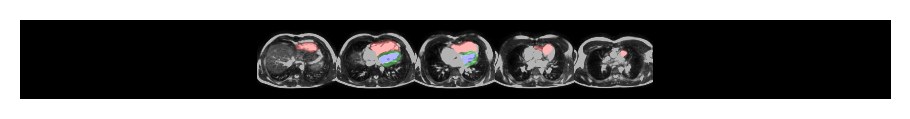

2020-12-18 12:30:15,113 INFO inv mask shape: (20, 256, 256, 4), gt mask shape: (20, 256, 256, 4)
2020-12-18 12:30:15,120 INFO DICE LV: 0.8422418236732483
2020-12-18 12:30:15,127 INFO DICE RV: 0.8340347409248352
2020-12-18 12:30:15,133 INFO DICE MYO: 0.6433149576187134
2020-12-18 12:30:15,134 INFO m: [[ 0.4172 -0.7837 -0.4597 -0.999 ]
 [ 0.3474 -0.3298  0.878  -0.999 ]
 [-0.84   -0.526   0.1346 15.734 ]]
2020-12-18 12:30:15,134 INFO m_mod: [[ 0.4172 -0.7837 -0.4597 -0.4966]
 [ 0.3474 -0.3298  0.878  -0.533 ]
 [-0.84   -0.526   0.1346  1.509 ]]
2020-12-18 12:30:15,135 INFO m_scaled: [[ 0.4172 -0.7837 -0.4597 -1.998 ]
 [ 0.3474 -0.3298  0.878  -1.998 ]
 [-0.84   -0.526   0.1346 31.47  ]]
2020-12-18 12:30:15,135 INFO 0000-FANDNZ55_2007-02-19_ED_msk.nrrd
2020-12-18 12:30:20,439 INFO DICE LV: 0.935215175151825
2020-12-18 12:30:20,538 INFO DICE RV: 0.8444600105285645
2020-12-18 12:30:20,626 INFO DICE MYO: 0.7116898894309998
2020-12-18 12:30:21,186 INFO Predicted mask rotated to AX on original

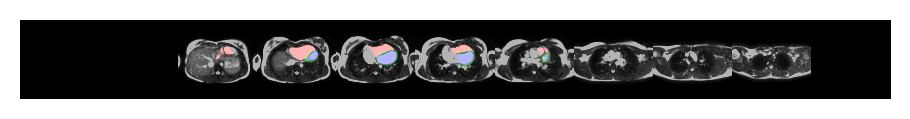

2020-12-18 12:30:22,898 INFO GT on AX


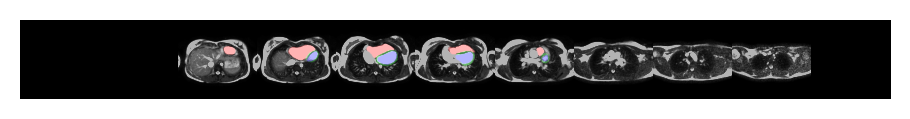

2020-12-18 12:30:23,422 INFO inv mask shape: (30, 256, 256, 4), gt mask shape: (30, 256, 256, 4)
2020-12-18 12:30:23,430 INFO DICE LV: 0.936560869216919
2020-12-18 12:30:23,438 INFO DICE RV: 0.8563719391822815
2020-12-18 12:30:23,445 INFO DICE MYO: 0.7277644872665405
2020-12-18 12:30:23,446 INFO m: [[ 0.4207 -0.7993 -0.4292 -0.999 ]
 [ 0.3442 -0.297   0.8906 -0.999 ]
 [-0.8394 -0.5225  0.15   15.38  ]]
2020-12-18 12:30:23,447 INFO m_mod: [[ 0.4207 -0.7993 -0.4292 -0.4888]
 [ 0.3442 -0.297   0.8906 -0.5254]
 [-0.8394 -0.5225  0.15    1.475 ]]
2020-12-18 12:30:23,447 INFO m_scaled: [[ 0.4207 -0.7993 -0.4292 -1.998 ]
 [ 0.3442 -0.297   0.8906 -1.998 ]
 [-0.8394 -0.5225  0.15   30.77  ]]
2020-12-18 12:30:23,448 INFO 0000-FANDNZ55_2007-02-19_ES_msk.nrrd
2020-12-18 12:30:28,880 INFO DICE LV: 0.8655928373336792
2020-12-18 12:30:28,963 INFO DICE RV: 0.8266966342926025
2020-12-18 12:30:29,044 INFO DICE MYO: 0.7470451593399048
2020-12-18 12:30:29,562 INFO Predicted mask rotated to AX on original

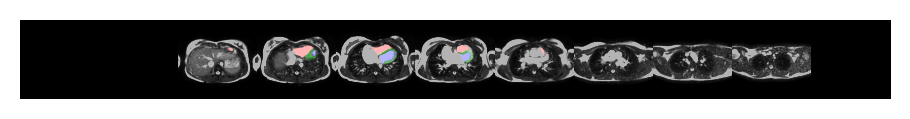

2020-12-18 12:30:30,022 INFO GT on AX


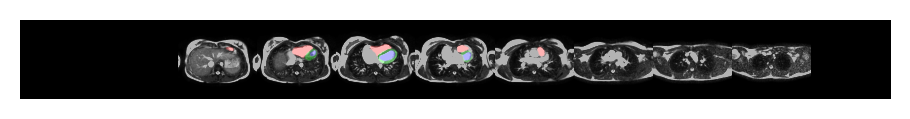

2020-12-18 12:30:30,553 INFO inv mask shape: (30, 256, 256, 4), gt mask shape: (30, 256, 256, 4)
2020-12-18 12:30:30,563 INFO DICE LV: 0.8757355809211731
2020-12-18 12:30:30,571 INFO DICE RV: 0.8256543874740601
2020-12-18 12:30:30,580 INFO DICE MYO: 0.7624662518501282
2020-12-18 12:30:30,581 INFO m: [[ 0.4219 -0.803  -0.42   -0.999 ]
 [ 0.3435 -0.287   0.894  -0.9985]
 [-0.839  -0.5215  0.1548 15.27  ]]
2020-12-18 12:30:30,581 INFO m_mod: [[ 0.4219 -0.803  -0.42   -0.4863]
 [ 0.3435 -0.287   0.894  -0.5225]
 [-0.839  -0.5215  0.1548  1.465 ]]
2020-12-18 12:30:30,582 INFO m_scaled: [[ 0.4219 -0.803  -0.42   -1.998 ]
 [ 0.3435 -0.287   0.894  -1.997 ]
 [-0.839  -0.5215  0.1548 30.55  ]]
2020-12-18 12:30:30,583 INFO 0000-FHQU30DQ_2005-05-10_ED_msk.nrrd
2020-12-18 12:30:35,823 INFO DICE LV: 0.8216062188148499
2020-12-18 12:30:35,907 INFO DICE RV: 0.7200464010238647
2020-12-18 12:30:35,987 INFO DICE MYO: 0.5435741543769836
2020-12-18 12:30:36,536 INFO Predicted mask rotated to AX on origina

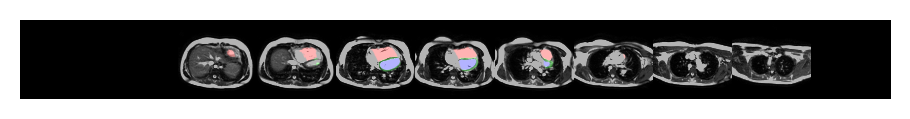

2020-12-18 12:30:36,987 INFO GT on AX


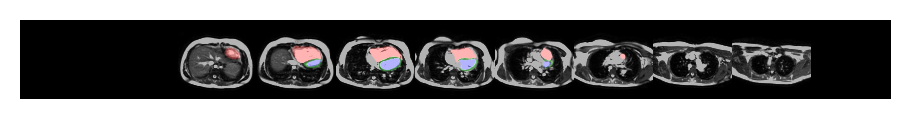

2020-12-18 12:30:37,509 INFO inv mask shape: (30, 256, 256, 4), gt mask shape: (30, 256, 256, 4)
2020-12-18 12:30:37,518 INFO DICE LV: 0.8157303333282471
2020-12-18 12:30:37,527 INFO DICE RV: 0.7218504548072815
2020-12-18 12:30:37,536 INFO DICE MYO: 0.5488948822021484
2020-12-18 12:30:37,537 INFO m: [[ 0.4165 -0.778  -0.4702 -0.999 ]
 [ 0.3484 -0.341   0.873  -0.999 ]
 [-0.84   -0.5273  0.1289 15.85  ]]
2020-12-18 12:30:37,537 INFO m_mod: [[ 0.4165 -0.778  -0.4702 -0.499 ]
 [ 0.3484 -0.341   0.873  -0.536 ]
 [-0.84   -0.5273  0.1289  1.52  ]]
2020-12-18 12:30:37,538 INFO m_scaled: [[ 0.4165 -0.778  -0.4702 -1.998 ]
 [ 0.3484 -0.341   0.873  -1.998 ]
 [-0.84   -0.5273  0.1289 31.7   ]]
2020-12-18 12:30:37,538 INFO 0000-FHQU30DQ_2005-05-10_ES_msk.nrrd
2020-12-18 12:30:42,840 INFO DICE LV: 0.7098082304000854
2020-12-18 12:30:42,922 INFO DICE RV: 0.6456693410873413
2020-12-18 12:30:43,002 INFO DICE MYO: 0.5826507806777954
2020-12-18 12:30:43,521 INFO Predicted mask rotated to AX on origina

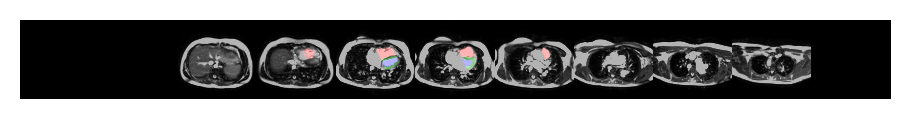

2020-12-18 12:30:43,975 INFO GT on AX


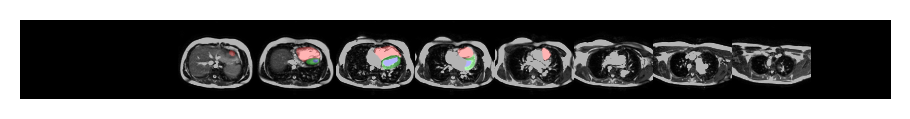

2020-12-18 12:30:44,499 INFO inv mask shape: (30, 256, 256, 4), gt mask shape: (30, 256, 256, 4)
2020-12-18 12:30:44,508 INFO DICE LV: 0.7018226385116577
2020-12-18 12:30:44,515 INFO DICE RV: 0.6487078666687012
2020-12-18 12:30:44,523 INFO DICE MYO: 0.5834760665893555
2020-12-18 12:30:44,524 INFO m: [[ 0.4165 -0.7783 -0.4695 -0.999 ]
 [ 0.3484 -0.3403  0.8735 -0.999 ]
 [-0.84   -0.5273  0.1294 15.836 ]]
2020-12-18 12:30:44,524 INFO m_mod: [[ 0.4165 -0.7783 -0.4695 -0.4985]
 [ 0.3484 -0.3403  0.8735 -0.535 ]
 [-0.84   -0.5273  0.1294  1.518 ]]
2020-12-18 12:30:44,524 INFO m_scaled: [[ 0.4165 -0.7783 -0.4695 -1.998 ]
 [ 0.3484 -0.3403  0.8735 -1.998 ]
 [-0.84   -0.5273  0.1294 31.67  ]]
2020-12-18 12:30:44,525 INFO 0000-G8XJ03CH_2007-10-31_ED_msk.nrrd
2020-12-18 12:30:50,037 INFO DICE LV: 0.9037312865257263
2020-12-18 12:30:50,134 INFO DICE RV: 0.7276984453201294
2020-12-18 12:30:50,230 INFO DICE MYO: 0.6600320339202881
2020-12-18 12:30:50,864 INFO Predicted mask rotated to AX on origina

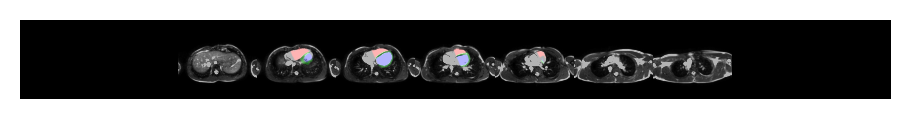

2020-12-18 12:30:51,332 INFO GT on AX


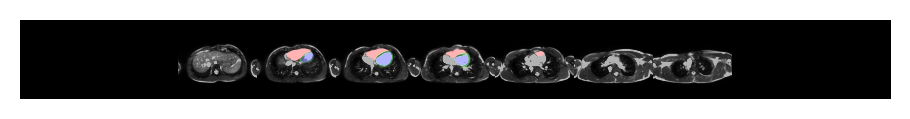

2020-12-18 12:30:51,842 INFO inv mask shape: (25, 256, 256, 4), gt mask shape: (25, 256, 256, 4)
2020-12-18 12:30:51,850 INFO DICE LV: 0.9038867354393005
2020-12-18 12:30:51,859 INFO DICE RV: 0.7302902936935425
2020-12-18 12:30:51,867 INFO DICE MYO: 0.65223628282547
2020-12-18 12:30:51,868 INFO m: [[ 0.4097 -0.738  -0.5366 -0.9995]
 [ 0.3555 -0.413   0.839  -0.9995]
 [-0.8403 -0.5347  0.093  16.69  ]]
2020-12-18 12:30:51,869 INFO m_mod: [[ 0.4097 -0.738  -0.5366 -0.5166]
 [ 0.3555 -0.413   0.839  -0.554 ]
 [-0.8403 -0.5347  0.093   1.601 ]]
2020-12-18 12:30:51,869 INFO m_scaled: [[ 0.4097 -0.738  -0.5366 -1.999 ]
 [ 0.3555 -0.413   0.839  -1.999 ]
 [-0.8403 -0.5347  0.093  33.38  ]]
2020-12-18 12:30:51,870 INFO 0000-G8XJ03CH_2007-10-31_ES_msk.nrrd
2020-12-18 12:30:57,296 INFO DICE LV: 0.8246639966964722
2020-12-18 12:30:57,394 INFO DICE RV: 0.7932074666023254
2020-12-18 12:30:57,477 INFO DICE MYO: 0.7301203012466431
2020-12-18 12:30:58,037 INFO Predicted mask rotated to AX on original 

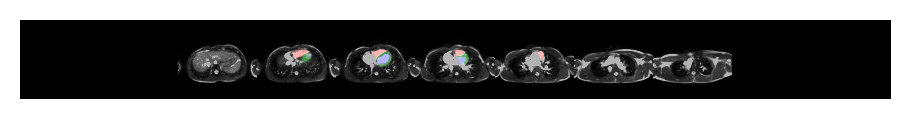

2020-12-18 12:30:58,502 INFO GT on AX


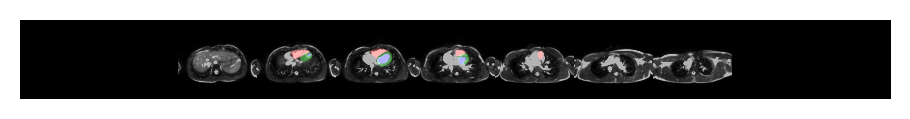

2020-12-18 12:30:59,019 INFO inv mask shape: (25, 256, 256, 4), gt mask shape: (25, 256, 256, 4)
2020-12-18 12:30:59,026 INFO DICE LV: 0.8169371485710144
2020-12-18 12:30:59,033 INFO DICE RV: 0.7928882241249084
2020-12-18 12:30:59,040 INFO DICE MYO: 0.7250590324401855
2020-12-18 12:30:59,041 INFO m: [[ 0.4087 -0.732  -0.546  -0.9995]
 [ 0.3567 -0.4226  0.8335 -0.9995]
 [-0.8403 -0.535   0.0883 16.8   ]]
2020-12-18 12:30:59,041 INFO m_mod: [[ 0.4087 -0.732  -0.546  -0.5195]
 [ 0.3567 -0.4226  0.8335 -0.5566]
 [-0.8403 -0.535   0.0883  1.611 ]]
2020-12-18 12:30:59,042 INFO m_scaled: [[ 0.4087 -0.732  -0.546  -1.999 ]
 [ 0.3567 -0.4226  0.8335 -1.999 ]
 [-0.8403 -0.535   0.0883 33.6   ]]
2020-12-18 12:30:59,043 INFO 0000-GYMP57R6_2006-12-18_ED_msk.nrrd
2020-12-18 12:31:04,279 INFO DICE LV: 0.9101498126983643
2020-12-18 12:31:04,365 INFO DICE RV: 0.8123822808265686
2020-12-18 12:31:04,447 INFO DICE MYO: 0.7090963125228882
2020-12-18 12:31:04,970 INFO Predicted mask rotated to AX on origina

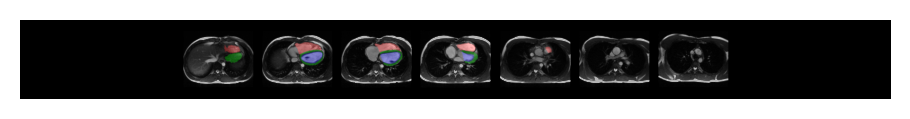

2020-12-18 12:31:05,427 INFO GT on AX


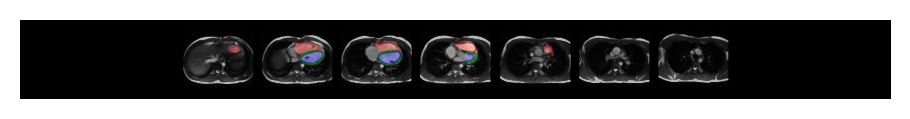

2020-12-18 12:31:05,906 INFO inv mask shape: (26, 156, 192, 4), gt mask shape: (26, 156, 192, 4)
2020-12-18 12:31:05,910 INFO DICE LV: 0.918578565120697
2020-12-18 12:31:05,914 INFO DICE RV: 0.8160741329193115
2020-12-18 12:31:05,919 INFO DICE MYO: 0.7261186242103577
2020-12-18 12:31:05,919 INFO m: [[ 0.4055  -0.7104  -0.5747  -0.9995 ]
 [ 0.3596  -0.454    0.815   -0.9995 ]
 [-0.8403  -0.537    0.07153 17.19   ]]
2020-12-18 12:31:05,920 INFO m_mod: [[ 0.4055  -0.7104  -0.5747  -0.5273 ]
 [ 0.3596  -0.454    0.815   -0.565  ]
 [-0.8403  -0.537    0.07153  1.649  ]]
2020-12-18 12:31:05,920 INFO m_scaled: [[ 0.4055  -0.7104  -0.5747  -1.999  ]
 [ 0.3596  -0.454    0.815   -1.999  ]
 [-0.8403  -0.537    0.07153 34.38   ]]
2020-12-18 12:31:05,921 INFO 0000-GYMP57R6_2006-12-18_ES_msk.nrrd
2020-12-18 12:31:11,213 INFO DICE LV: 0.8850386738777161
2020-12-18 12:31:11,301 INFO DICE RV: 0.7500974535942078
2020-12-18 12:31:11,384 INFO DICE MYO: 0.7548202276229858
2020-12-18 12:31:11,938 INFO Pred

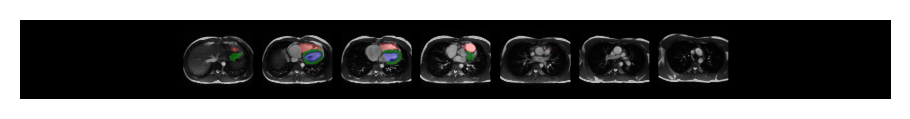

2020-12-18 12:31:12,389 INFO GT on AX


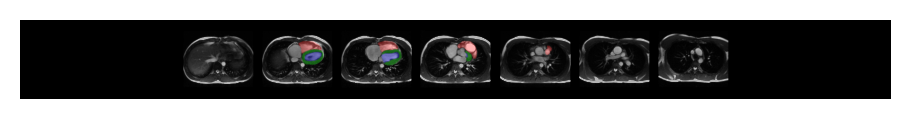

2020-12-18 12:31:12,867 INFO inv mask shape: (26, 156, 192, 4), gt mask shape: (26, 156, 192, 4)
2020-12-18 12:31:12,872 INFO DICE LV: 0.8921940922737122
2020-12-18 12:31:12,877 INFO DICE RV: 0.7662754058837891
2020-12-18 12:31:12,882 INFO DICE MYO: 0.7656570672988892
2020-12-18 12:31:12,883 INFO m: [[ 0.406   -0.714   -0.571   -0.9995 ]
 [ 0.3596  -0.4497   0.818   -0.9995 ]
 [-0.8403  -0.5376   0.07416 17.14   ]]
2020-12-18 12:31:12,884 INFO m_mod: [[ 0.406   -0.714   -0.571   -0.5264 ]
 [ 0.3596  -0.4497   0.818   -0.5635 ]
 [-0.8403  -0.5376   0.07416  1.645  ]]
2020-12-18 12:31:12,884 INFO m_scaled: [[ 0.406   -0.714   -0.571   -1.999  ]
 [ 0.3596  -0.4497   0.818   -1.999  ]
 [-0.8403  -0.5376   0.07416 34.28   ]]
2020-12-18 12:31:12,885 INFO 0000-GYRF6ZAA_2004-08-01_ED_msk.nrrd
2020-12-18 12:31:18,163 INFO DICE LV: 0.8857384324073792
2020-12-18 12:31:18,245 INFO DICE RV: 0.8376012444496155
2020-12-18 12:31:18,325 INFO DICE MYO: 0.6560459136962891
2020-12-18 12:31:18,840 INFO Pre

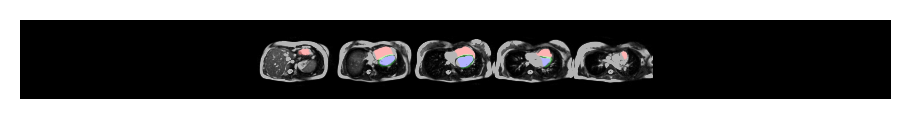

2020-12-18 12:31:19,286 INFO GT on AX


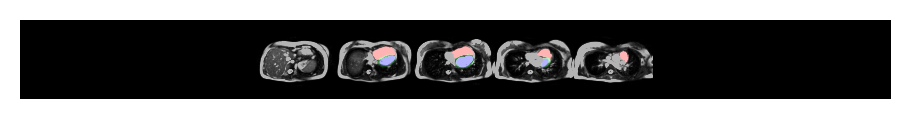

2020-12-18 12:31:19,761 INFO inv mask shape: (12, 256, 256, 4), gt mask shape: (12, 256, 256, 4)
2020-12-18 12:31:19,765 INFO DICE LV: 0.8936275839805603
2020-12-18 12:31:19,771 INFO DICE RV: 0.8325544595718384
2020-12-18 12:31:19,776 INFO DICE MYO: 0.6641102433204651
2020-12-18 12:31:19,776 INFO m: [[ 0.4155 -0.772  -0.4814 -0.999 ]
 [ 0.3496 -0.353   0.868  -0.999 ]
 [-0.84   -0.529   0.1233 15.98  ]]
2020-12-18 12:31:19,777 INFO m_mod: [[ 0.4155 -0.772  -0.4814 -0.502 ]
 [ 0.3496 -0.353   0.868  -0.5386]
 [-0.84   -0.529   0.1233  1.531 ]]
2020-12-18 12:31:19,778 INFO m_scaled: [[ 0.4155 -0.772  -0.4814 -1.998 ]
 [ 0.3496 -0.353   0.868  -1.998 ]
 [-0.84   -0.529   0.1233 31.95  ]]
2020-12-18 12:31:19,779 INFO 0000-GYRF6ZAA_2004-08-01_ES_msk.nrrd
2020-12-18 12:31:25,055 INFO DICE LV: 0.8207035660743713
2020-12-18 12:31:25,141 INFO DICE RV: 0.8287714123725891
2020-12-18 12:31:25,223 INFO DICE MYO: 0.7425270080566406
2020-12-18 12:31:25,759 INFO Predicted mask rotated to AX on origina

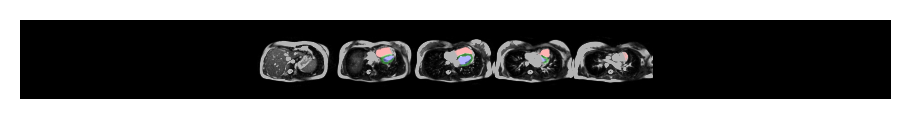

2020-12-18 12:31:26,207 INFO GT on AX


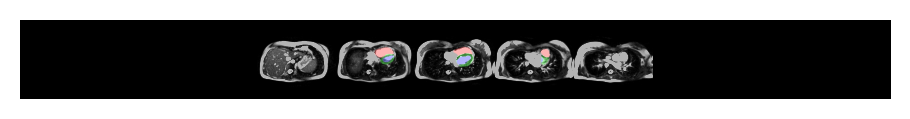

2020-12-18 12:31:26,681 INFO inv mask shape: (12, 256, 256, 4), gt mask shape: (12, 256, 256, 4)
2020-12-18 12:31:26,686 INFO DICE LV: 0.8363010883331299
2020-12-18 12:31:26,690 INFO DICE RV: 0.8452545404434204
2020-12-18 12:31:26,694 INFO DICE MYO: 0.7682278752326965
2020-12-18 12:31:26,695 INFO m: [[ 0.4136 -0.7603 -0.5015 -0.9995]
 [ 0.3518 -0.3748  0.858  -0.999 ]
 [-0.84   -0.5312  0.1124 16.22  ]]
2020-12-18 12:31:26,695 INFO m_mod: [[ 0.4136 -0.7603 -0.5015 -0.507 ]
 [ 0.3518 -0.3748  0.858  -0.544 ]
 [-0.84   -0.5312  0.1124  1.556 ]]
2020-12-18 12:31:26,696 INFO m_scaled: [[ 0.4136 -0.7603 -0.5015 -1.999 ]
 [ 0.3518 -0.3748  0.858  -1.998 ]
 [-0.84   -0.5312  0.1124 32.44  ]]
2020-12-18 12:31:26,696 INFO 0000-JDRPF7F4_2006-02-28_ED_msk.nrrd
2020-12-18 12:31:31,977 INFO DICE LV: 0.7420471906661987
2020-12-18 12:31:32,069 INFO DICE RV: 0.4512687027454376
2020-12-18 12:31:32,159 INFO DICE MYO: 0.5323829650878906
2020-12-18 12:31:32,795 INFO Predicted mask rotated to AX on origina

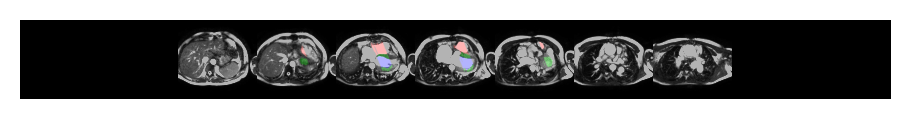

2020-12-18 12:31:33,265 INFO GT on AX


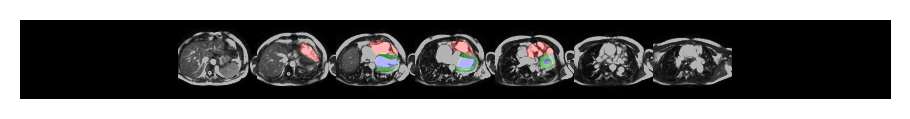

2020-12-18 12:31:33,806 INFO inv mask shape: (25, 256, 256, 4), gt mask shape: (25, 256, 256, 4)
2020-12-18 12:31:33,814 INFO DICE LV: 0.7288944721221924
2020-12-18 12:31:33,823 INFO DICE RV: 0.4214797019958496
2020-12-18 12:31:33,831 INFO DICE MYO: 0.5130606889724731
2020-12-18 12:31:33,831 INFO m: [[ 0.4172 -0.7827 -0.4612 -0.999 ]
 [ 0.3474 -0.3315  0.877  -0.999 ]
 [-0.84   -0.5264  0.1335 15.734 ]]
2020-12-18 12:31:33,832 INFO m_mod: [[ 0.4172 -0.7827 -0.4612 -0.4966]
 [ 0.3474 -0.3315  0.877  -0.533 ]
 [-0.84   -0.5264  0.1335  1.509 ]]
2020-12-18 12:31:33,833 INFO m_scaled: [[ 0.4172 -0.7827 -0.4612 -1.998 ]
 [ 0.3474 -0.3315  0.877  -1.998 ]
 [-0.84   -0.5264  0.1335 31.47  ]]
2020-12-18 12:31:33,833 INFO 0000-JDRPF7F4_2006-02-28_ES_msk.nrrd
2020-12-18 12:31:39,111 INFO DICE LV: 0.8319534063339233
2020-12-18 12:31:39,203 INFO DICE RV: 0.6106852889060974
2020-12-18 12:31:39,294 INFO DICE MYO: 0.5813795328140259
2020-12-18 12:31:39,918 INFO Predicted mask rotated to AX on origina

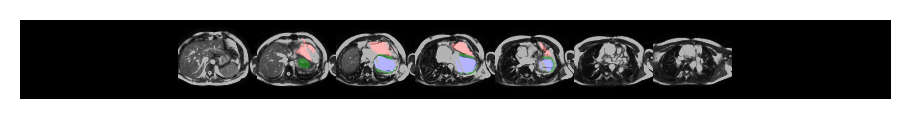

2020-12-18 12:31:41,618 INFO GT on AX


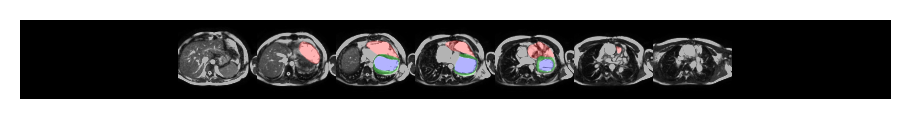

2020-12-18 12:31:42,136 INFO inv mask shape: (25, 256, 256, 4), gt mask shape: (25, 256, 256, 4)
2020-12-18 12:31:42,144 INFO DICE LV: 0.8349831700325012
2020-12-18 12:31:42,152 INFO DICE RV: 0.6111717820167542
2020-12-18 12:31:42,159 INFO DICE MYO: 0.5951159596443176
2020-12-18 12:31:42,160 INFO m: [[ 0.418  -0.784  -0.4585 -0.999 ]
 [ 0.3474 -0.3284  0.8784 -0.999 ]
 [-0.8394 -0.5264  0.1353 15.7   ]]
2020-12-18 12:31:42,161 INFO m_mod: [[ 0.418  -0.784  -0.4585 -0.4956]
 [ 0.3474 -0.3284  0.8784 -0.532 ]
 [-0.8394 -0.5264  0.1353  1.505 ]]
2020-12-18 12:31:42,162 INFO m_scaled: [[ 0.418  -0.784  -0.4585 -1.998 ]
 [ 0.3474 -0.3284  0.8784 -1.998 ]
 [-0.8394 -0.5264  0.1353 31.4   ]]
2020-12-18 12:31:42,163 INFO 0000-JP6XAZWH_2007-03-02_ED_msk.nrrd
2020-12-18 12:31:47,575 INFO DICE LV: 0.8681090474128723
2020-12-18 12:31:47,667 INFO DICE RV: 0.7945327162742615
2020-12-18 12:31:47,759 INFO DICE MYO: 0.6479452848434448
2020-12-18 12:31:48,333 INFO Predicted mask rotated to AX on origina

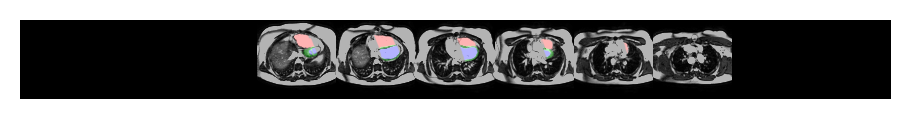

2020-12-18 12:31:48,796 INFO GT on AX


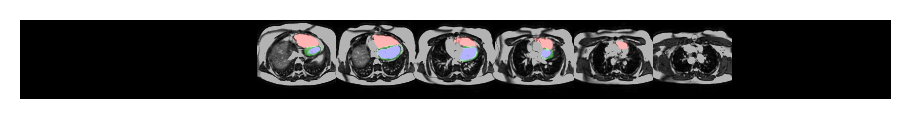

2020-12-18 12:31:49,314 INFO inv mask shape: (24, 256, 256, 4), gt mask shape: (24, 256, 256, 4)
2020-12-18 12:31:49,321 INFO DICE LV: 0.8664059638977051
2020-12-18 12:31:49,328 INFO DICE RV: 0.8055949211120605
2020-12-18 12:31:49,335 INFO DICE MYO: 0.6427070498466492
2020-12-18 12:31:49,336 INFO m: [[ 0.4265 -0.822  -0.3782 -0.9985]
 [ 0.3394 -0.2424  0.909  -0.9985]
 [-0.8384 -0.516   0.1753 14.77  ]]
2020-12-18 12:31:49,336 INFO m_mod: [[ 0.4265 -0.822  -0.3782 -0.4746]
 [ 0.3394 -0.2424  0.909  -0.5107]
 [-0.8384 -0.516   0.1753  1.416 ]]
2020-12-18 12:31:49,337 INFO m_scaled: [[ 0.4265 -0.822  -0.3782 -1.997 ]
 [ 0.3394 -0.2424  0.909  -1.997 ]
 [-0.8384 -0.516   0.1753 29.55  ]]
2020-12-18 12:31:49,338 INFO 0000-JP6XAZWH_2007-03-02_ES_msk.nrrd
2020-12-18 12:31:55,664 INFO DICE LV: 0.7678121328353882
2020-12-18 12:31:55,756 INFO DICE RV: 0.693213701248169
2020-12-18 12:31:55,848 INFO DICE MYO: 0.7232693433761597
2020-12-18 12:31:56,381 INFO Predicted mask rotated to AX on original

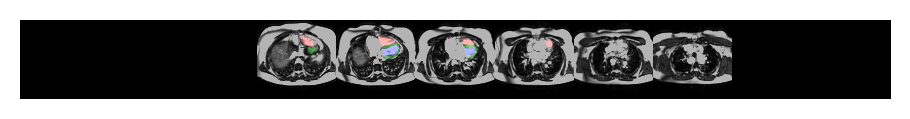

2020-12-18 12:31:56,834 INFO GT on AX


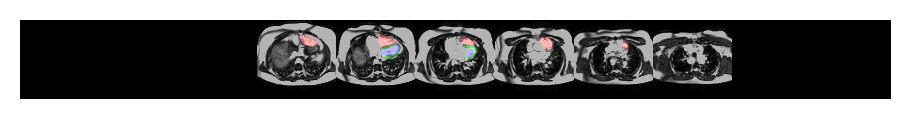

2020-12-18 12:31:57,345 INFO inv mask shape: (24, 256, 256, 4), gt mask shape: (24, 256, 256, 4)
2020-12-18 12:31:57,353 INFO DICE LV: 0.7620336413383484
2020-12-18 12:31:57,361 INFO DICE RV: 0.6941942572593689
2020-12-18 12:31:57,369 INFO DICE MYO: 0.7122957706451416
2020-12-18 12:31:57,370 INFO m: [[ 0.4253 -0.8184 -0.3862 -0.9985]
 [ 0.3398 -0.2512  0.9062 -0.9985]
 [-0.839  -0.5166  0.1711 14.875 ]]
2020-12-18 12:31:57,370 INFO m_mod: [[ 0.4253 -0.8184 -0.3862 -0.477 ]
 [ 0.3398 -0.2512  0.9062 -0.5137]
 [-0.839  -0.5166  0.1711  1.426 ]]
2020-12-18 12:31:57,371 INFO m_scaled: [[ 0.4253 -0.8184 -0.3862 -1.997 ]
 [ 0.3398 -0.2512  0.9062 -1.997 ]
 [-0.839  -0.5166  0.1711 29.75  ]]
2020-12-18 12:31:57,372 INFO 0000-K4HCL72E_2007-03-27_ED_msk.nrrd
2020-12-18 12:32:02,650 INFO DICE LV: 0.9113195538520813
2020-12-18 12:32:02,788 INFO DICE RV: 0.8413429260253906
2020-12-18 12:32:02,892 INFO DICE MYO: 0.7029225826263428
2020-12-18 12:32:03,421 INFO Predicted mask rotated to AX on origina

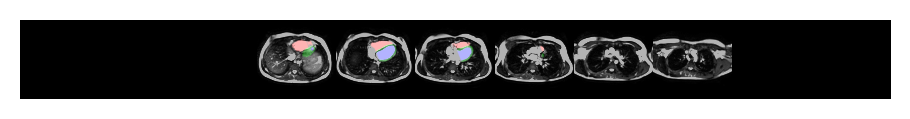

2020-12-18 12:32:03,869 INFO GT on AX


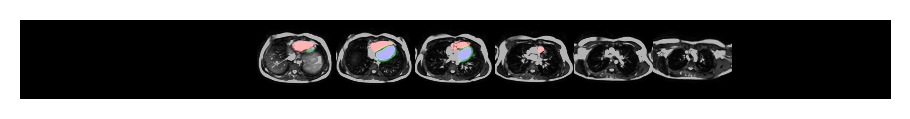

2020-12-18 12:32:04,373 INFO inv mask shape: (23, 256, 256, 4), gt mask shape: (23, 256, 256, 4)
2020-12-18 12:32:04,380 INFO DICE LV: 0.9110694527626038
2020-12-18 12:32:04,387 INFO DICE RV: 0.8455736041069031
2020-12-18 12:32:04,396 INFO DICE MYO: 0.6942965388298035
2020-12-18 12:32:04,396 INFO m: [[ 0.4182 -0.7856 -0.455  -0.999 ]
 [ 0.347  -0.3247  0.8794 -0.999 ]
 [-0.8394 -0.526   0.1368 15.67  ]]
2020-12-18 12:32:04,397 INFO m_mod: [[ 0.4182 -0.7856 -0.455  -0.495 ]
 [ 0.347  -0.3247  0.8794 -0.5317]
 [-0.8394 -0.526   0.1368  1.503 ]]
2020-12-18 12:32:04,397 INFO m_scaled: [[ 0.4182 -0.7856 -0.455  -1.998 ]
 [ 0.347  -0.3247  0.8794 -1.998 ]
 [-0.8394 -0.526   0.1368 31.34  ]]
2020-12-18 12:32:04,398 INFO 0000-K4HCL72E_2007-03-27_ES_msk.nrrd
2020-12-18 12:32:09,706 INFO DICE LV: 0.8735834956169128
2020-12-18 12:32:09,866 INFO DICE RV: 0.7594601511955261
2020-12-18 12:32:09,970 INFO DICE MYO: 0.769610583782196
2020-12-18 12:32:10,513 INFO Predicted mask rotated to AX on original

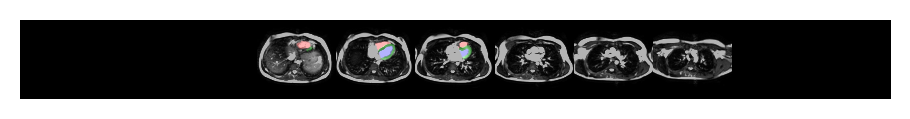

2020-12-18 12:32:10,959 INFO GT on AX


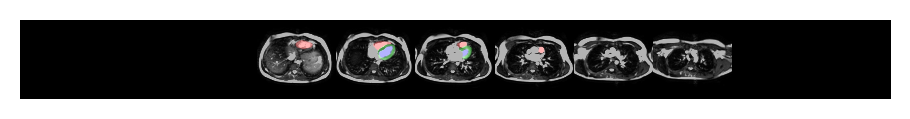

2020-12-18 12:32:11,456 INFO inv mask shape: (23, 256, 256, 4), gt mask shape: (23, 256, 256, 4)
2020-12-18 12:32:11,463 INFO DICE LV: 0.8743576407432556
2020-12-18 12:32:11,468 INFO DICE RV: 0.7786620259284973
2020-12-18 12:32:11,475 INFO DICE MYO: 0.7602492570877075
2020-12-18 12:32:11,475 INFO m: [[ 0.4182 -0.786  -0.4556 -0.999 ]
 [ 0.3472 -0.3252  0.88   -0.999 ]
 [-0.8394 -0.526   0.1368 15.68  ]]
2020-12-18 12:32:11,476 INFO m_mod: [[ 0.4182 -0.786  -0.4556 -0.495 ]
 [ 0.3472 -0.3252  0.88   -0.532 ]
 [-0.8394 -0.526   0.1368  1.504 ]]
2020-12-18 12:32:11,476 INFO m_scaled: [[ 0.4182 -0.786  -0.4556 -1.998 ]
 [ 0.3472 -0.3252  0.88   -1.998 ]
 [-0.8394 -0.526   0.1368 31.36  ]]
2020-12-18 12:32:11,477 INFO 0000-K61NJJ2D_2007-05-29_ED_msk.nrrd
2020-12-18 12:32:16,791 INFO DICE LV: 0.9033429622650146
2020-12-18 12:32:16,915 INFO DICE RV: 0.8347769379615784
2020-12-18 12:32:17,014 INFO DICE MYO: 0.5140330195426941
2020-12-18 12:32:17,539 INFO Predicted mask rotated to AX on origina

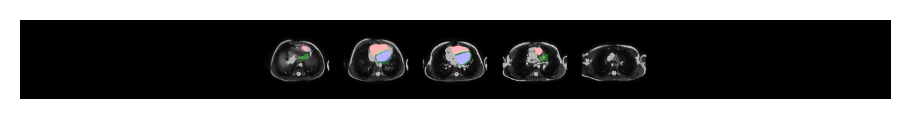

2020-12-18 12:32:17,991 INFO GT on AX


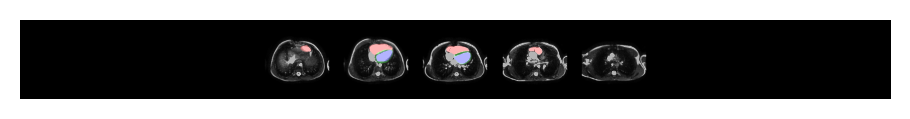

2020-12-18 12:32:18,480 INFO inv mask shape: (19, 288, 288, 4), gt mask shape: (19, 288, 288, 4)
2020-12-18 12:32:18,488 INFO DICE LV: 0.903622567653656
2020-12-18 12:32:18,497 INFO DICE RV: 0.8318781852722168
2020-12-18 12:32:18,505 INFO DICE MYO: 0.4889693856239319
2020-12-18 12:32:18,506 INFO m: [[ 0.4053  -0.7075  -0.5786  -0.9995 ]
 [ 0.3599  -0.4585   0.8125  -0.9995 ]
 [-0.8403  -0.5376   0.06885 17.23   ]]
2020-12-18 12:32:18,507 INFO m_mod: [[ 0.4053  -0.7075  -0.5786  -0.5283 ]
 [ 0.3599  -0.4585   0.8125  -0.566  ]
 [-0.8403  -0.5376   0.06885  1.652  ]]
2020-12-18 12:32:18,507 INFO m_scaled: [[ 0.4053  -0.7075  -0.5786  -1.999  ]
 [ 0.3599  -0.4585   0.8125  -1.999  ]
 [-0.8403  -0.5376   0.06885 34.47   ]]
2020-12-18 12:32:18,508 INFO 0000-K61NJJ2D_2007-05-29_ES_msk.nrrd
2020-12-18 12:32:24,808 INFO DICE LV: 0.8188219666481018
2020-12-18 12:32:24,913 INFO DICE RV: 0.7503785490989685
2020-12-18 12:32:25,028 INFO DICE MYO: 0.648009181022644
2020-12-18 12:32:25,558 INFO Predi

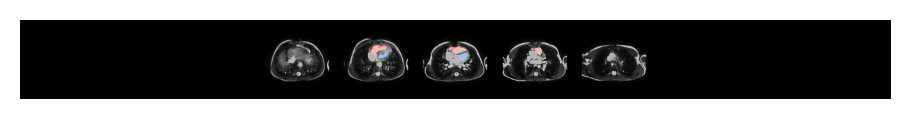

2020-12-18 12:32:26,006 INFO GT on AX


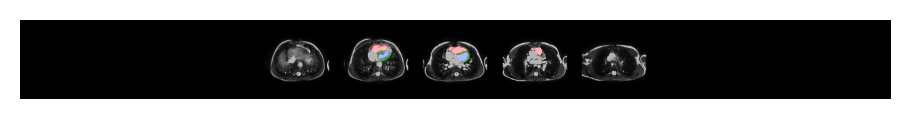

2020-12-18 12:32:26,493 INFO inv mask shape: (19, 288, 288, 4), gt mask shape: (19, 288, 288, 4)
2020-12-18 12:32:26,501 INFO DICE LV: 0.8209125995635986
2020-12-18 12:32:26,510 INFO DICE RV: 0.7537073493003845
2020-12-18 12:32:26,518 INFO DICE MYO: 0.6371626257896423
2020-12-18 12:32:26,519 INFO m: [[ 0.4055  -0.7104  -0.5747  -0.9995 ]
 [ 0.3596  -0.454    0.815   -0.9995 ]
 [-0.8403  -0.537    0.07153 17.19   ]]
2020-12-18 12:32:26,519 INFO m_mod: [[ 0.4055  -0.7104  -0.5747  -0.5273 ]
 [ 0.3596  -0.454    0.815   -0.565  ]
 [-0.8403  -0.537    0.07153  1.647  ]]
2020-12-18 12:32:26,520 INFO m_scaled: [[ 0.4055  -0.7104  -0.5747  -1.999  ]
 [ 0.3596  -0.454    0.815   -1.999  ]
 [-0.8403  -0.537    0.07153 34.38   ]]


In [26]:
# predict on all test images, once with postprocessing, and once without
experiment_identifier = config['EXPERIMENT'].replace('/', '_') + 'no_post_no_mod'
export_path = 'data/predicted/{}/3D/'.format(experiment_identifier)
use_modified_translation =  FOCUS_LOSS # True, if we use the unet extension to learn a second set of translation parameters
slice_n = 5
debug = False
save = True
postprocess = False
logging.info('Use modified translation to scale: {}'.format(use_modified_translation))

# make predictions with different parameters in the same flow
for i in range(ax_full.shape[0]):
    select_image_in_batch_(im=i,
                           slice_n=slice_n, 
                           debug=debug,
                           export_path=export_path,
                           save=save,
                           postprocess=postprocess,
                           use_mod_translation=use_modified_translation)

# Further tests, where do our model fail, do we over- or under-segment

In [15]:
print(temp_ax.shape)
print(temp_pred.shape)
print(temp_gt.shape)

(22, 256, 256)
(22, 256, 256, 4)
(22, 256, 256, 4)


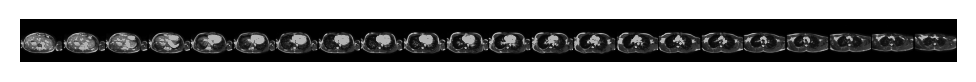

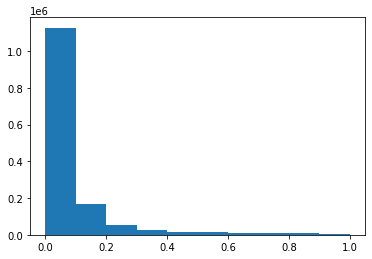

In [18]:
# did we clip the quantiles correctely, does the histogram match the raw data?
from src.data.Preprocess import clip_quantile
temp = temp_ax[:]

show_2D_or_3D(temp)
plt.show()
plt.hist(temp.flatten())
plt.show()


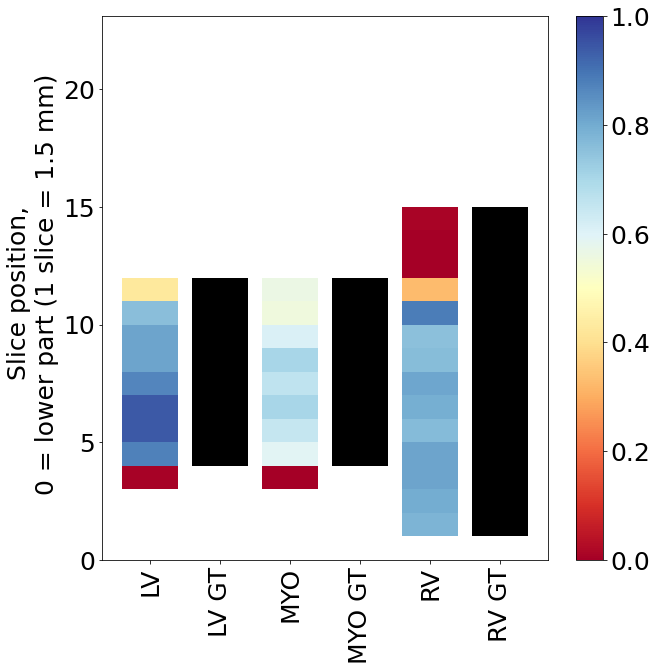

In [23]:
from src.visualization.Visualize import plot_dice_per_slice_bar, plot_dice_per_slice_line
plot_dice_per_slice_bar(temp_gt[...,1:],temp_pred[...,1:])